## Load data

In [1]:
# %pip install itables
from itables import init_notebook_mode
import itables.options as opt

# Ativa o modo interativo
init_notebook_mode(all_interactive=True)

# 1. Botões de exportação
opt.buttons = ["copy", "csv", "excel", "pdf"]

# 2. Estilo CSS (display e nowrap ajudam na formatação)
opt.classes = ["display", "nowrap"]

# 3. CONFIGURAÇÃO DE SCROLL (O Segredo está aqui)
opt.scrollY = "400px"       # Define a altura fixa (cria scroll vertical se passar disto)
opt.scrollCollapse = True   # Se a tabela for pequena, ela encolhe (não fica com espaço branco)
opt.scrollX = True          # Cria scroll horizontal se houver muitas colunas
opt.paging = False          # Desliga a paginação para poderes fazer scroll infinito verticalmente
                            # (Se preferires páginas, muda para True, mas o scrollY continua a funcionar)

# Opcional: Definir largura da tabela para 100% ou um valor fixo
# opt.style = "width:100%"

In [5]:
from data.loader import load_complete_dataset
from data.preprocessing import add_module_columns
from config.constants import DEVICES
%load_ext autoreload
%autoreload 2

In [6]:
dataset = load_complete_dataset(14)
dataset = add_module_columns(dataset)

In [13]:
dataset.columns

Index(['device_id', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
       'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'magnetometer_x',
       'magnetometer_y', 'magnetometer_z', 'timestamp', 'actitivy_label',
       'participant_id', 'magnetometer_module', 'gyroscope_module',
       'accelerometer_module'],
      dtype='object')

In [2]:
from config.constants import ACRONYM_LABELS
ACRONYM_LABELS

['STD',
 'SIT',
 'SIT-T',
 'WLK',
 'WLK-T',
 'STR',
 'STR-T',
 'STD->SIT',
 'SIT->STD',
 'STD->SIT-T',
 'SIT->STD-T',
 'STD->WLK',
 'WLK->STD',
 'STD->STR',
 'STR->WLK',
 'STR-T->WLK-T']

Gerando boxplots para 5 dispositivos...


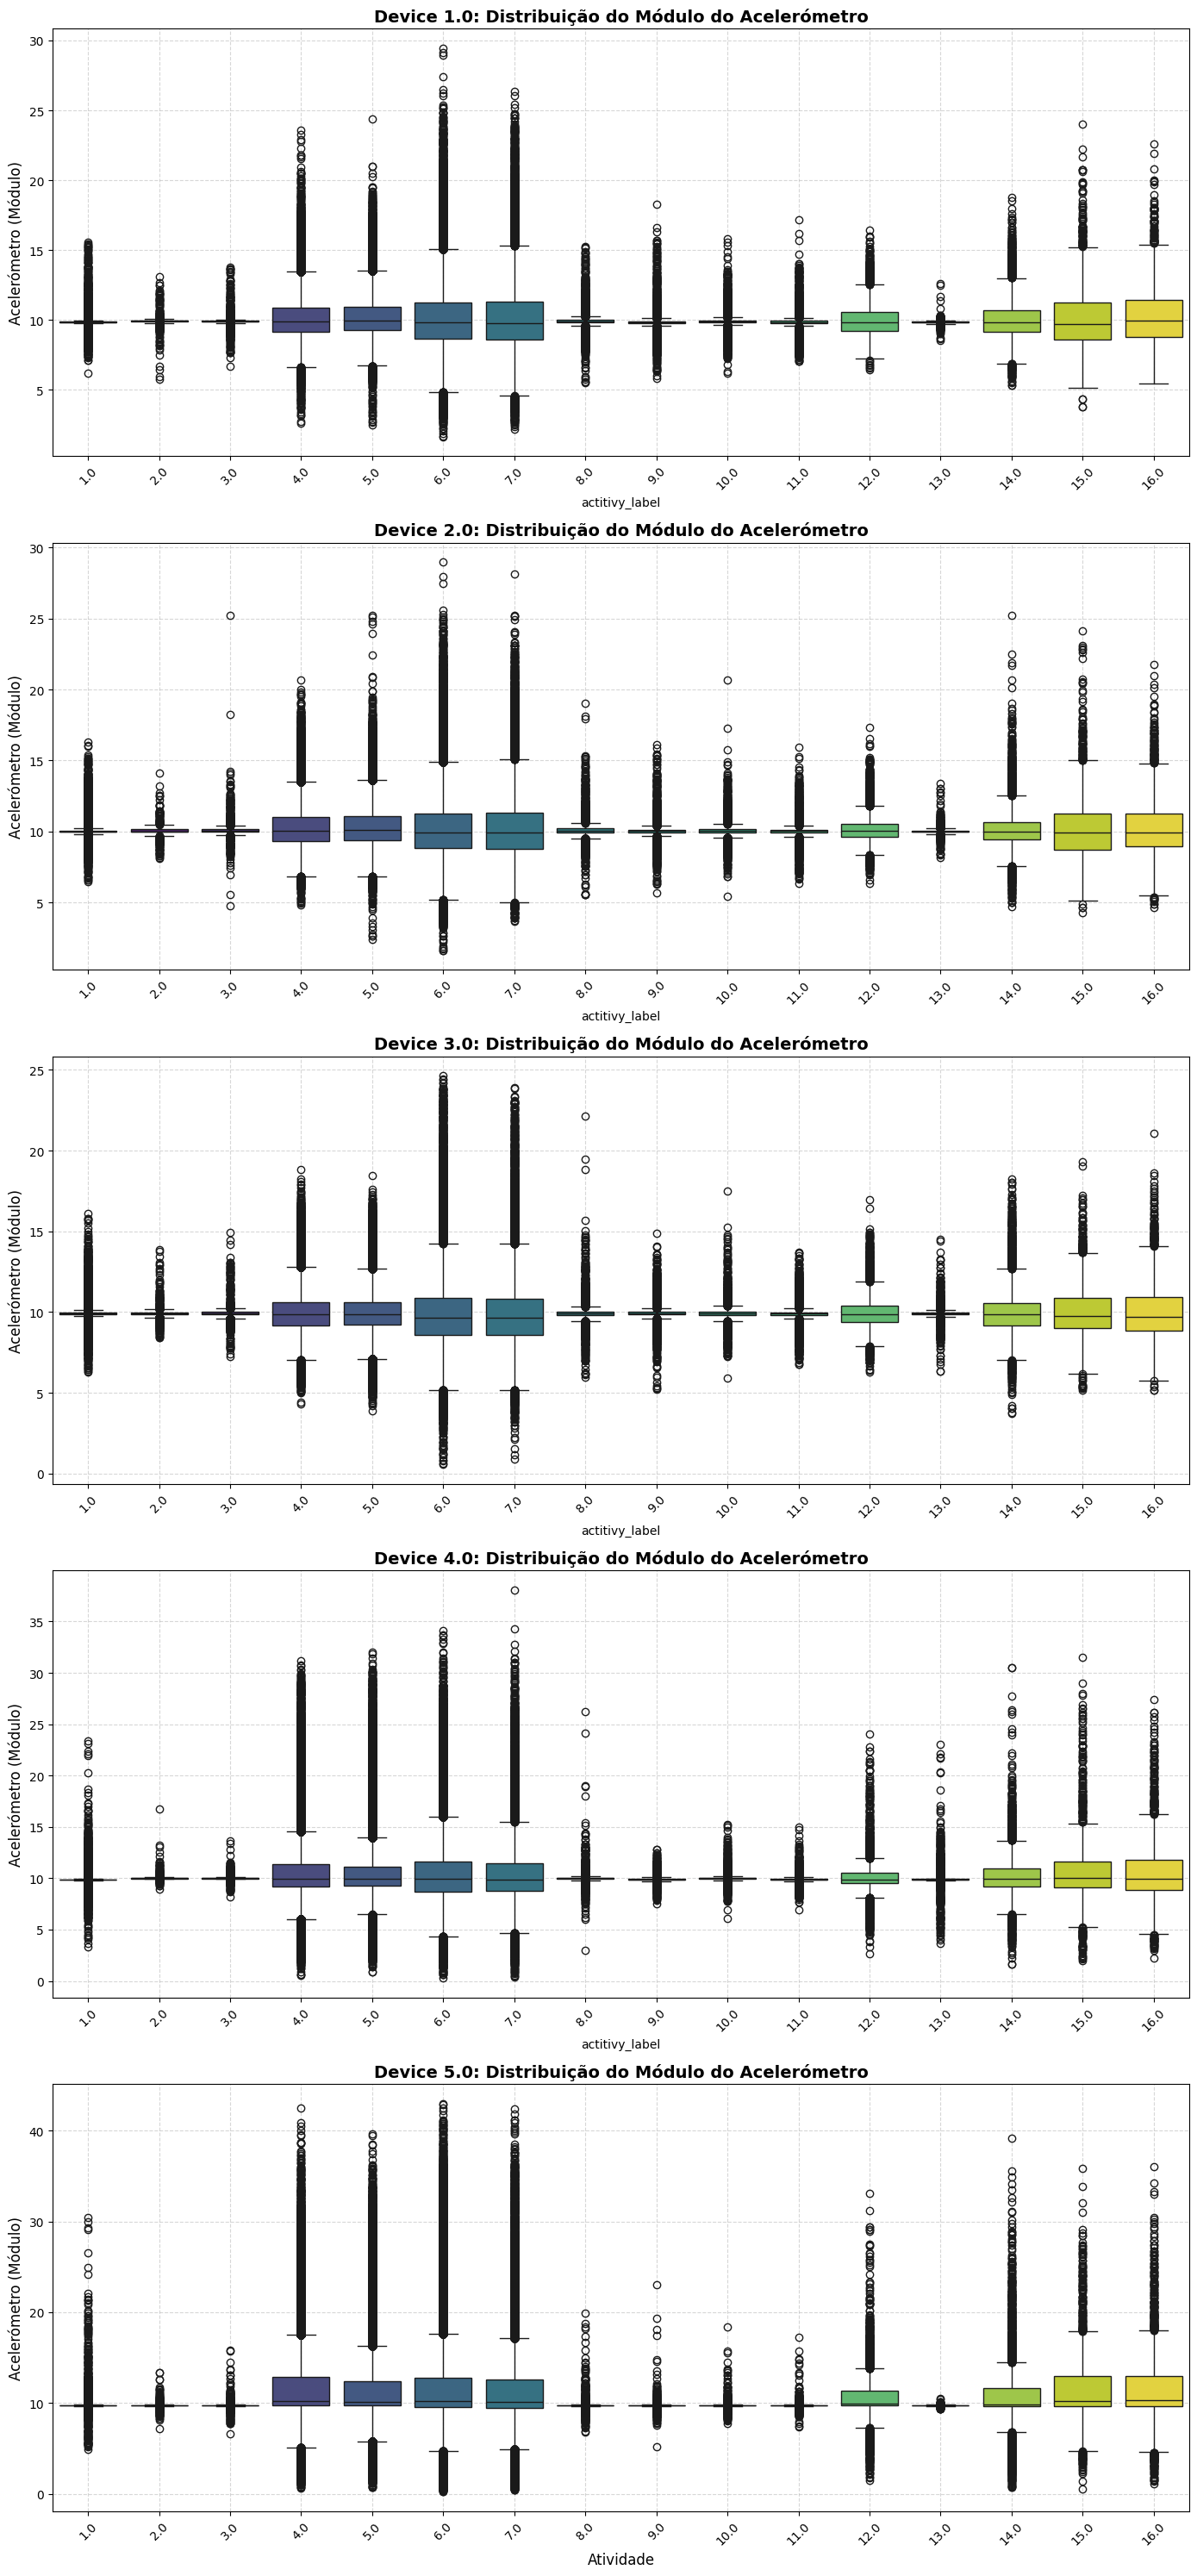

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


devices = sorted(dataset['device_id'].unique())
n_devices = len(devices)
fig, axes = plt.subplots(n_devices, 1, figsize=(14, 6 * n_devices), sharex=False)


activity_order = sorted(dataset['actitivy_label'].unique())

print(f"Gerando boxplots para {n_devices} dispositivos...")

# 3. Loop para criar cada gráfico
for i, dev_id in enumerate(devices):
    # Filtrar dados apenas deste sensor
    subset = dataset[dataset['device_id'] == dev_id]
    
    ax = axes[i] if n_devices > 1 else axes
    
    # Criar o Boxplot
    sns.boxplot(
        data=subset,
        x='actitivy_label',
        y='accelerometer_module',
        order=activity_order,   # Mantém a ordem das atividades fixa
        hue='actitivy_label',   # Cores diferentes por atividade
        palette='viridis',      # Paleta de cores agradável
        ax=ax,
        legend=False            # Remove legenda redundante
    )
    
    # Estética
    ax.set_title(f"Device {dev_id}: Distribuição do Módulo do Acelerómetro", fontsize=14, fontweight='bold')
    ax.set_ylabel("Acelerómetro (Módulo)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Rodar os labels do eixo X para não sobrepor (se os nomes forem longos)
    ax.tick_params(axis='x', rotation=45)

# Ajustes finais de layout
plt.xlabel("Atividade", fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import pandas as pd
def calc_outliers(col,dataset,scaling_factor):    
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_limit = Q1 - scaling_factor * IQR
    upper_limit = Q3 + scaling_factor * IQR
    
#    print(f"Limite inferior: {lower_limit}")
 #   print(f"Limite superior: {upper_limit}")
    
    
    mask_outliers = (dataset[col] <lower_limit) | (dataset[col] > upper_limit)

    densidade=np.sum(mask_outliers)/len(dataset)*100
  #  print(densidade)
    return densidade,mask_outliers

cols_modules = [
    "magnetometer_module",
    "gyroscope_module",
    "accelerometer_module"
]
results = []

for dev_id in dataset["device_id"].unique():    
    for label in dataset["actitivy_label"].unique():
        subset = dataset[(dataset["device_id"] == dev_id) & 
                         (dataset["actitivy_label"] == label)]
        for col in cols_modules:
           densidade,are_outliers= calc_outliers(col,subset,1.5)
           total_rows=len(subset)
           num_outliers=np.sum(are_outliers)
           results.append({
                "device_id": dev_id,
                "ActLabel": label,
                "coluna": col,
                "densidade_outliers(%)": densidade,
                "total_linhas": total_rows,
                "total_outliers": num_outliers
            })
           
df_resultados = pd.DataFrame(results,index=None)
df_pivot = df_resultados.pivot_table(
    index=['device_id', 'ActLabel'], 
    columns='coluna', 
    values=['densidade_outliers(%)', 'total_linhas', 'total_outliers']
)

# Opcional: O resultado acima cria colunas com níveis (MultiIndex).
# Se quiseres "achatar" os nomes das colunas (ex: "densidade_outliers(%)_accelerometer_module"):
df_pivot.columns = [f"{val}_{col}" for val, col in df_pivot.columns]

# Resetar o index para que device_id e ActLabel voltem a ser colunas normais
df_final = df_pivot.reset_index()

# Visualizar
display(df_final)

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


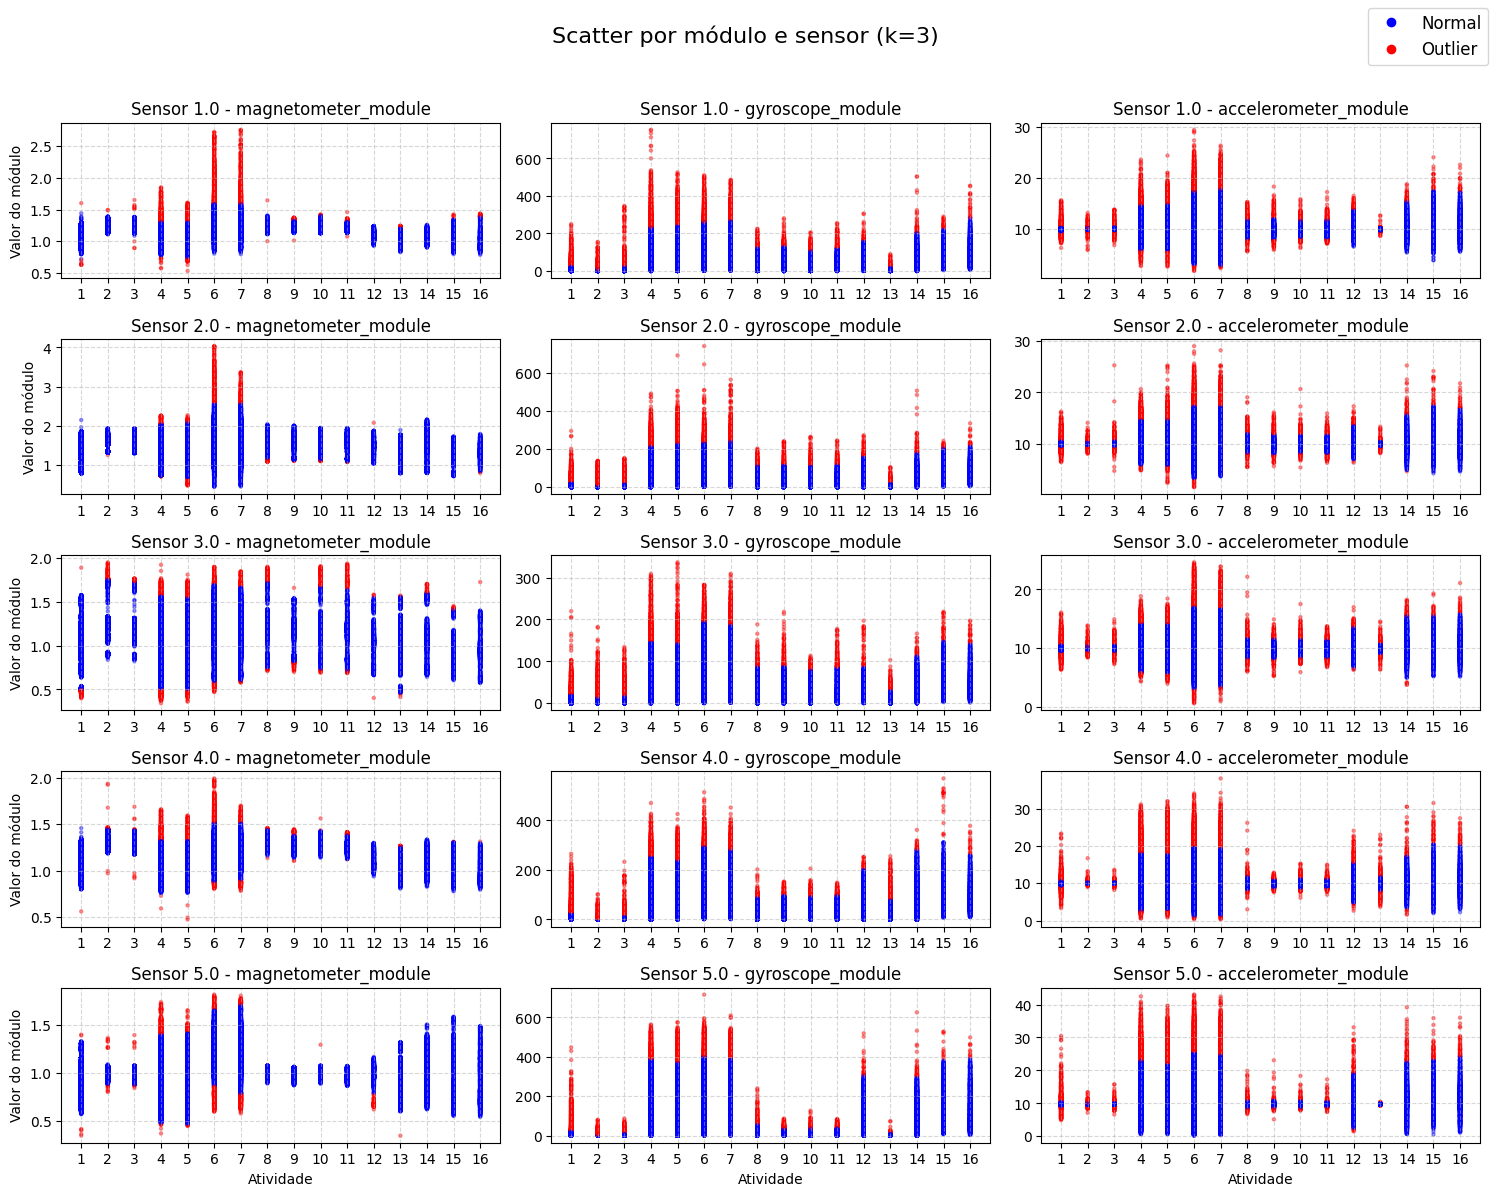

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.lines import Line2D

ks = [3, 3.5, 4]
modules = ["magnetometer_module", "gyroscope_module", "accelerometer_module"]
os.makedirs("plots_by_sensor", exist_ok=True)
sensors_to_plot = sorted(dataset["device_id"].unique())

# xticks comuns para todos os subplots
all_activities = sorted(dataset["actitivy_label"].unique())

for k in ks:
    fig, axes = plt.subplots(
        len(sensors_to_plot), len(modules), figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle(f"Scatter por módulo e sensor (k={k})", fontsize=16)

    for i, sensor_id in enumerate(sensors_to_plot):
        sensor_data = dataset[dataset["device_id"] == sensor_id]

        for j, module in enumerate(modules):
            ax = axes[i, j] if len(sensors_to_plot) > 1 else axes[j]

            # calcular outliers por grupo (atividade)
            mean_per_group = sensor_data.groupby("actitivy_label")[module].transform("mean")
            std_per_group = sensor_data.groupby("actitivy_label")[module].transform("std")
            z_scores = (sensor_data[module] - mean_per_group) / std_per_group
            colors = np.where(np.abs(z_scores) > k, "red", "blue")

            X = sensor_data["actitivy_label"].values
            Y = sensor_data[module].values

            ax.scatter(X, Y, s=5, alpha=0.4, c=colors)
            ax.set_title(f"Sensor {sensor_id} - {module}")
            if i == len(sensors_to_plot)-1:
                ax.set_xlabel("Atividade")
            if j == 0:
                ax.set_ylabel("Valor do módulo")    
            ax.grid(True, linestyle='--', alpha=0.5)

            # configurar xticks como inteiros
            ax.set_xticks(all_activities)
            ax.set_xticklabels([int(a) for a in all_activities])

    # legenda global de cores
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"plots_subplots_k{k}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
#random centers

def k_means(data,k,iterations, epsilon=1e-4):
    #funcoes internas, só existem dentro da funcao k_means
    def distance(p1,p2):
        return np.sqrt(np.sum((p1-p2)**2))
    
    def cluster_points(data,centers,groups_by_centers): #
        # calcula todas as distâncias de uma vez
        distances = np.sqrt(((data[:, np.newaxis, :] - centers[np.newaxis, :, :])**2).sum(axis=2)) ##otimizado
        cluster_ids = np.argmin(distances, axis=1)

        # atribui pontos aos grupos
        for i in range(k):
            groups_by_centers[i] = data[cluster_ids == i]
        return groups_by_centers
    
    def update_centers(groups_by_centers,centers,k):
        new_centers = centers.copy()
        for i in range(k):
            if len(groups_by_centers[i]) > 0:
                new_centers[i] = np.mean(groups_by_centers[i], axis=0)
        return new_centers
    

    #inicializar centros aleatoriamente
    n_samples = data.shape[0]
    centers = data[np.random.choice(n_samples, k, replace=False)]
    for i in range(iterations):
        groups_by_centers=[[] for _ in range(k)] # criar os grupos para guardar os pontos.
        groups_by_centers=cluster_points(data,centers,groups_by_centers)
        new_centers=update_centers(groups_by_centers,centers,k)
        # Critério de paragem: mudança mínima nos centróides
        shift = np.linalg.norm(new_centers - centers)
        if shift < epsilon:
            print(f"Paragem na iteração {i+1} (mudança {shift:.6f})")
            break

        centers = new_centers

    return centers,groups_by_centers

In [ ]:

import numpy as np
from sklearn.linear_model import LinearRegression


def gcv_linear_regression(X, y):
    n, p = X.shape

    model = LinearRegression()
    model.fit(X,y)
    
    y_pred = model.predict(X)
    residuals = y.flatten() - y_pred.flatten()
    rss = np.sum(residuals**2) # Residual Sum of Squares (RSS)
    
    
    XtX_inv = np.linalg.inv(X.T @ X)
    hat_matrix_trace = np.sum((X @ XtX_inv) * X)
    
    gcv = rss / (1 - hat_matrix_trace / n)**2

    return gcv, model

In [6]:
def k_means(data,k,iterations, epsilon=1e-4):
    #funcoes internas, só existem dentro da funcao k_means
    def distance(p1,p2):
        return np.sqrt(np.sum((p1-p2)**2))
    
    def cluster_points(data,centers,groups_by_centers): #
        # calcula todas as distâncias de uma vez
        distances = np.sqrt(((data[:, np.newaxis, :] - centers[np.newaxis, :, :])**2).sum(axis=2)) ##otimizado
        cluster_ids = np.argmin(distances, axis=1)

        # atribui pontos aos grupos
        for i in range(k):
            groups_by_centers[i] = data[cluster_ids == i]
        return groups_by_centers
    
    def update_centers(groups_by_centers,centers,k):
        new_centers = centers.copy()
        for i in range(k):
            if len(groups_by_centers[i]) > 0:
                new_centers[i] = np.mean(groups_by_centers[i], axis=0)
        return new_centers
    

    #inicializar centros aleatoriamente
    n_samples = data.shape[0]
    centers = data[np.random.choice(n_samples, k, replace=False)]
    for i in range(iterations):
        groups_by_centers=[[] for _ in range(k)] # criar os grupos para guardar os pontos.
        groups_by_centers=cluster_points(data,centers,groups_by_centers)
        new_centers=update_centers(groups_by_centers,centers,k)
        # Critério de paragem: mudança mínima nos centróides
        shift = np.linalg.norm(new_centers - centers)
        if shift < epsilon:
            print(f"Paragem na iteração {i+1} (mudança {shift:.6f})")
            break

        centers = new_centers

    return centers,groups_by_centers






modules_dataset=dataset[["accelerometer_module","gyroscope_module","magnetometer_module"]].to_numpy()
centers,groups_by_centers=k_means(data=modules_dataset,k=10,iterations=100)

KeyboardInterrupt: 

In [25]:
dataset["actitivy_label"].unique()

array([ 1.,  8.,  2.,  9., 10.,  3., 11., 12.,  4., 13.,  5., 14.,  6.,
       15.,  7., 16.])

In [21]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


A gerar Clusters e Gráficos 3D...


TypeError: float() argument must be a string or a real number, not 'StandardScaler'

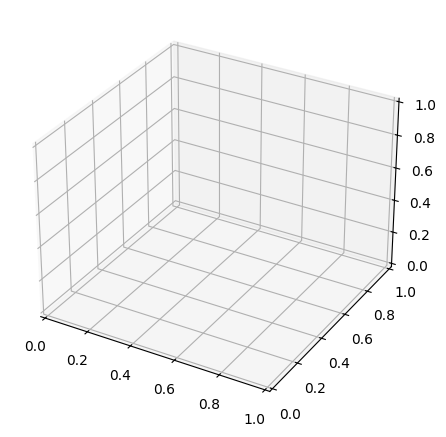

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler

from config.constants import COLUMNS_MODULE, DEVICE_LABELS

# ==============================================================================
# 1. PREPARAÇÃO DOS DADOS (CORREÇÃO DO ERRO)
# ==============================================================================

# CRÍTICO: Resetar o index para garantir que cada linha tem um ID único.
# Sem isto, o .loc falha se houver índices duplicados de ficheiros concatenados.
dataset = dataset.reset_index()
scaler = StandardScaler()
subset=scaler.fit(dataset[COLUMNS_MODULE])
# Inicializar a coluna Cluster
dataset['Cluster'] = -1 

# Configurações visuais
n_sensors = min(len(DEVICES), 5)
n_cols = 2
n_rows = int(np.ceil(n_sensors / n_cols))

fig = plt.figure(figsize=(15, 6 * n_rows))
gs = GridSpec(n_rows, n_cols, figure=fig)

print("A gerar Clusters e Gráficos 3D...")

# ==============================================================================
# 2. LOOP DE CLUSTERING E VISUALIZAÇÃO
# ==============================================================================

for i, sensor in enumerate(DEVICES[:n_sensors]):
    row = i // n_cols
    col = i % n_cols

    # Lógica de layout (centralizar o último se for ímpar)
    if (row == n_rows - 1) and (n_sensors % n_cols == 1):
        ax = fig.add_subplot(gs[row, 0:2], projection='3d')
    else:
        ax = fig.add_subplot(gs[row, col], projection='3d')

    # Filtrar dados (agora com índices únicos seguros)
    sensordata = dataset[dataset["device_id"] == sensor]
    
    # Se não houver dados para este sensor, saltar
    if sensordata.empty:
        continue
        
    modules = subset.to_numpy()

    # KMeans
    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(modules)
    centroids = kmeans.cluster_centers_

    # --- ATRIBUIÇÃO SEGURA ---
    # Graças ao reset_index, isto agora funciona perfeitamente
    dataset.loc[sensordata.index, 'Cluster'] = labels

    # Plot Scatter
    scatter = ax.scatter(
        modules[:, 0], modules[:, 1], modules[:, 2],
        c=labels, cmap='tab20', s=20, alpha=0.6
    )

    # Plot Centróides
    ax.scatter(
        centroids[:, 0], centroids[:, 1], centroids[:, 2],
        c='black', s=150, marker='X', label='Centróides'
    )

    # Legenda Personalizada
    unique_labels = np.unique(labels)
    colors = [plt.cm.tab20(l / 19) for l in unique_labels] # /19 para espalhar no colormap
    legend_patches = [mpatches.Patch(color=c, label=f'C {l}') for l, c in zip(unique_labels, colors)]
    
    # Colocar legenda fora ou num canto para não tapar dados
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, ncol=1, bbox_to_anchor=(-0.1, 1))

    ax.set_xlabel(COLUMNS_MODULE[0])
    ax.set_ylabel(COLUMNS_MODULE[1])
    ax.set_zlabel(COLUMNS_MODULE[2])
    ax.set_title(f'KMeans - {DEVICE_LABELS[i]} (ID: {sensor})')

plt.tight_layout()
plt.show()



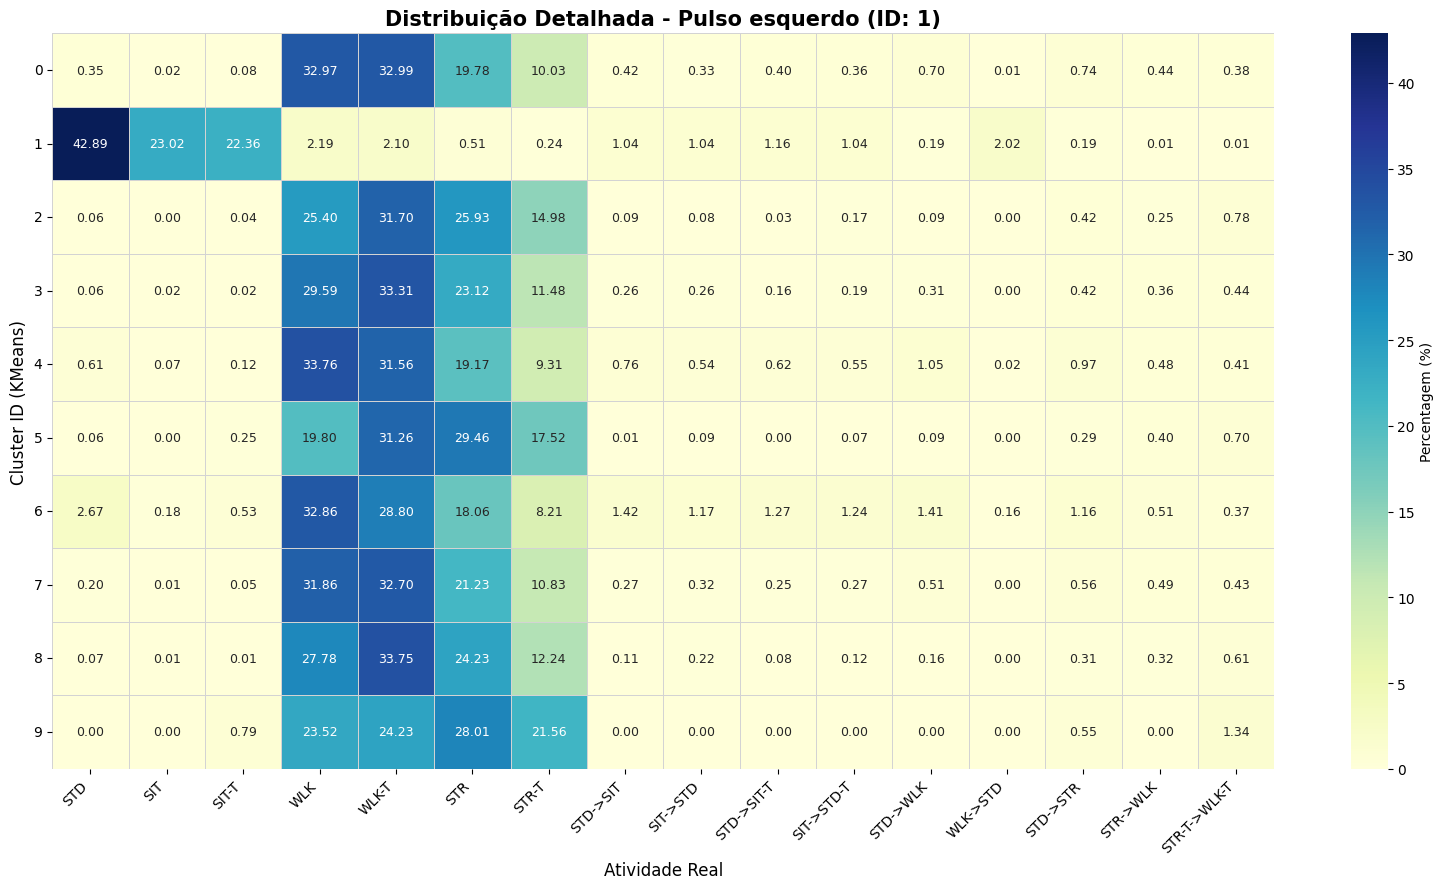

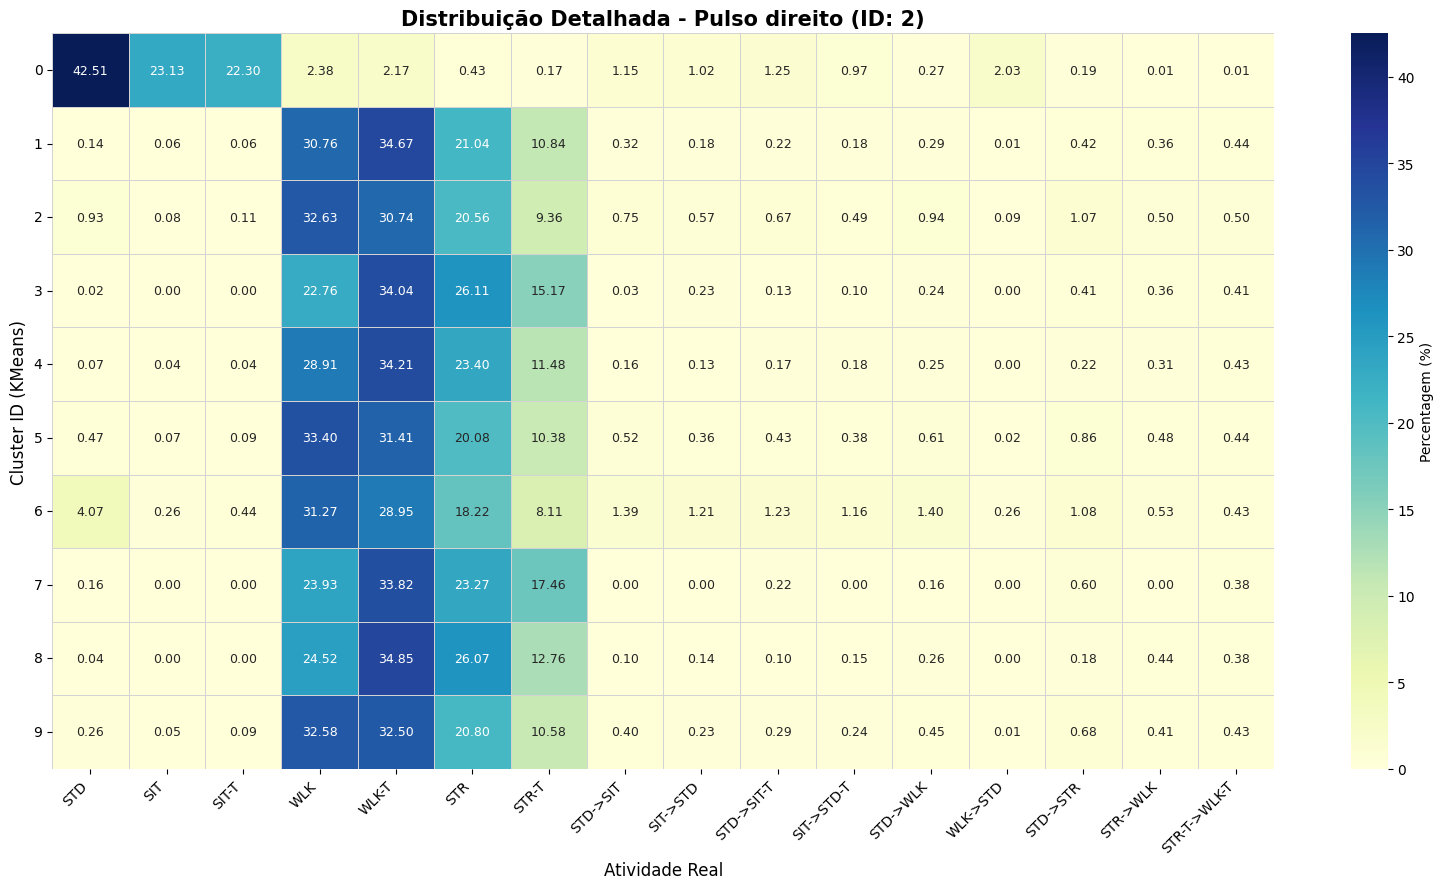

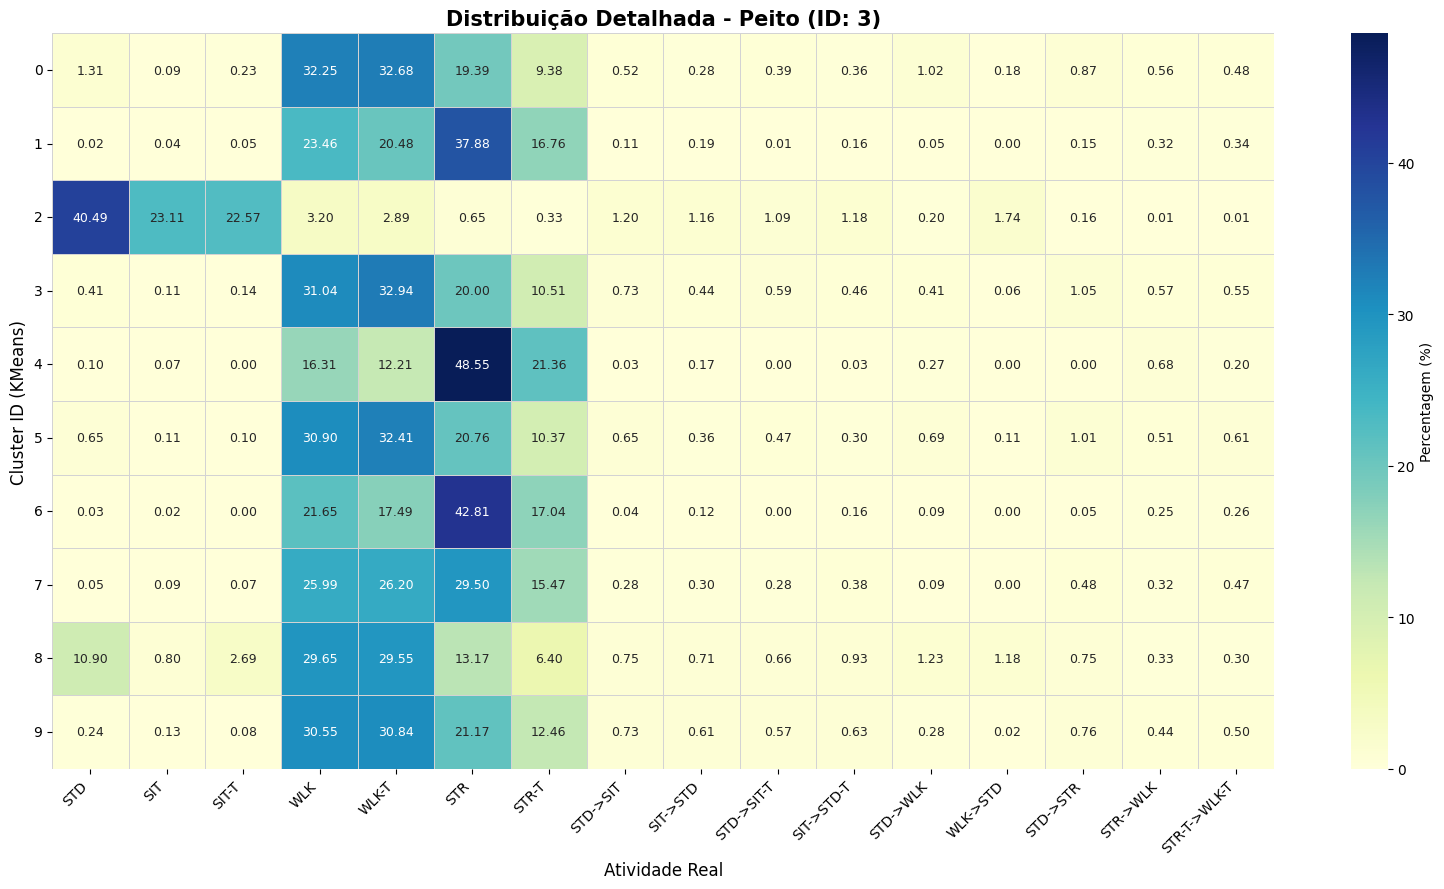

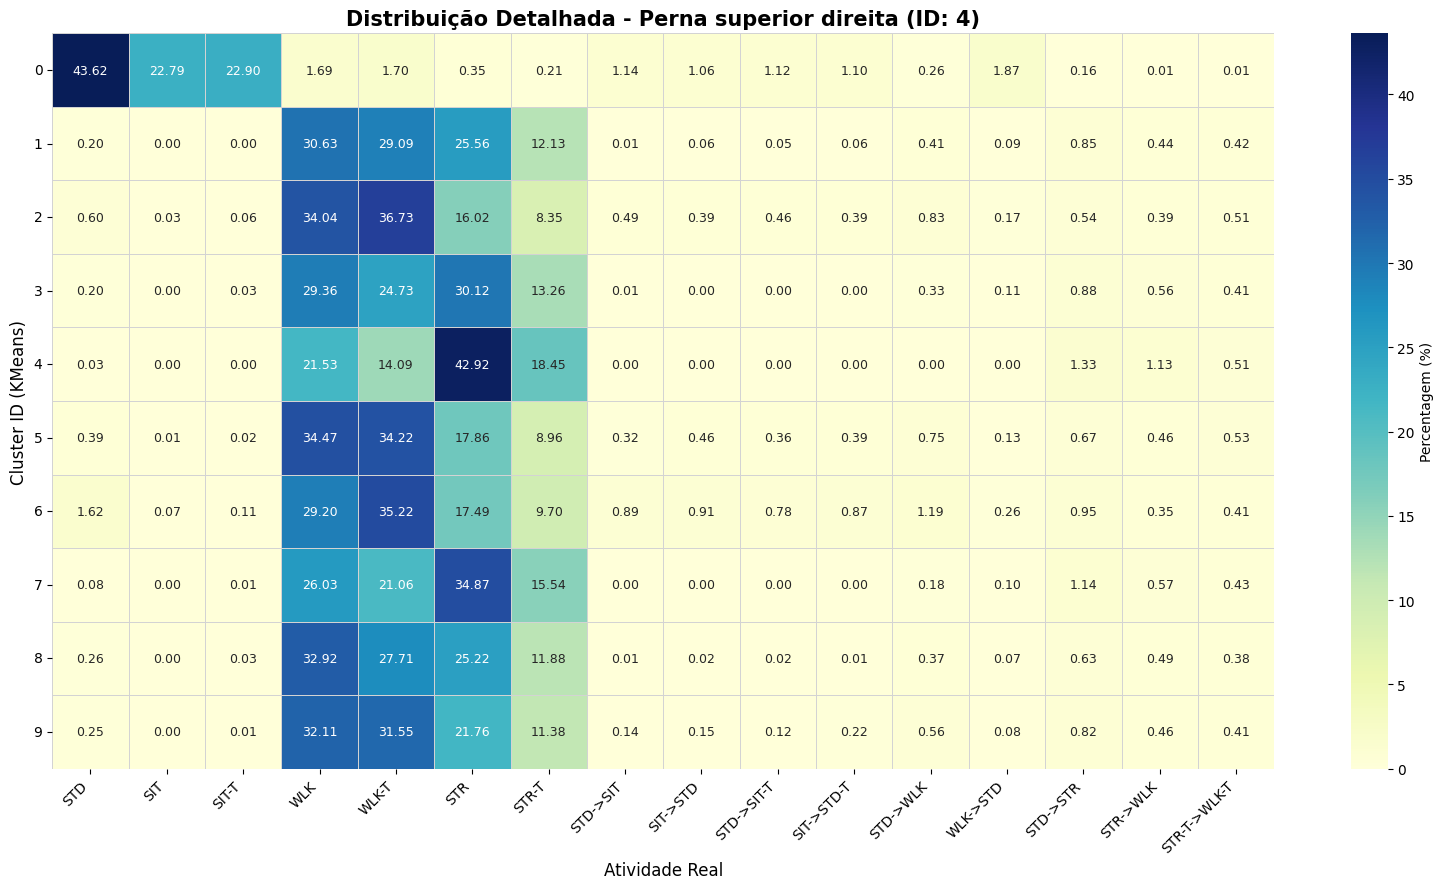

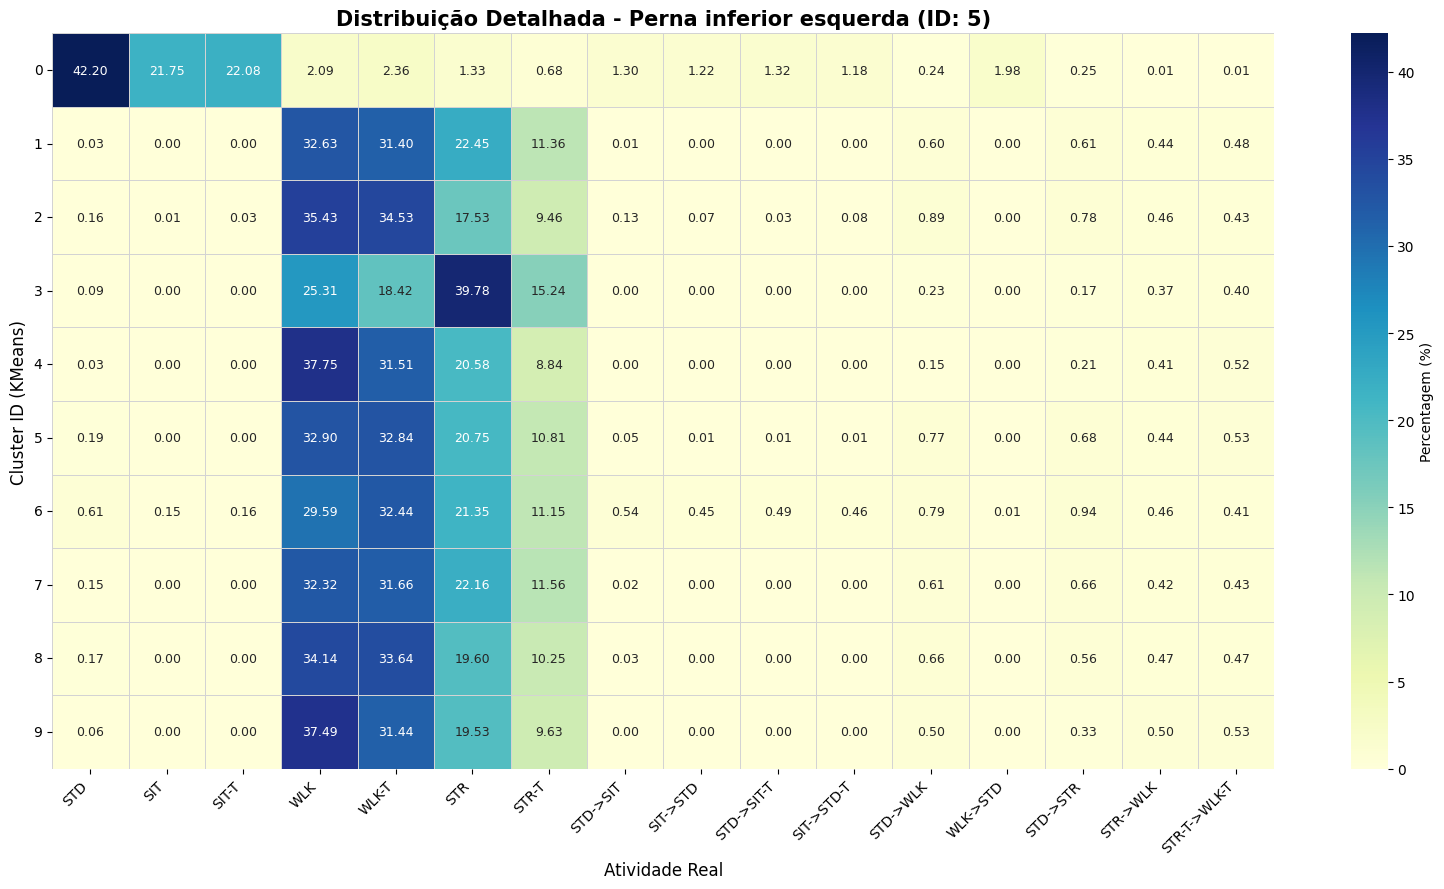

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from config.constants import ACTIVITY_LABELS, DEVICE_LABELS

ALL_LABELS_ORDERED = [id_to_label[i] for i in sorted(id_to_label.keys())]

for dev in unique_devs:
    dev_int = int(dev)
    
    if dev not in percentual.index.get_level_values(0):
        continue
    
    # Selecionar e Reindexar (para garantir que colunas a 0 aparecem)
    subset = percentual.loc[dev]
    subset = subset.reindex(columns=ALL_LABELS_ORDERED, fill_value=0)
    
    plt.figure(figsize=(16, 9))
    
    # Desenhar Heatmap com PRECISÃO DE 2 CASAS DECIMAIS
    ax = sns.heatmap(
        subset, 
        annot=True, 
        fmt=".2f",          # <--- MUDANÇA AQUI (antes estava .0f)
        annot_kws={"size": 9}, # Reduzir fonte para caber "100.00"
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentagem (%)'},
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # Títulos e Eixos
    label_name = DEVICE_LABELS[dev_int-1] if (dev_int-1) < len(DEVICE_LABELS) else f"Device {dev_int}"
    plt.title(f"Distribuição Detalhada - {label_name} (ID: {dev_int})", fontsize=15, fontweight='bold')
    plt.ylabel("Cluster ID (KMeans)", fontsize=12)
    plt.xlabel("Atividade Real", fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


In [28]:
import numpy as np
import pandas as pd

# ==============================================================================
# RELATÓRIO DE DENSIDADE (APENAS TEXTO)
# ==============================================================================
print("\n=== Relatório de Densidade por Sensor (Pontos & Percentagens) ===\n")

# 1. Filtrar apenas dados processados (Cluster != -1)
df_valid = dataset[dataset['Cluster'] != -1]
unique_devs = sorted(df_valid['device_id'].unique())

for dev in unique_devs:
    # Obter nome legível do sensor (se a lista existir)
    dev_int = int(dev)
    dev_name = DEVICE_LABELS[dev_int-1] if 'DEVICE_LABELS' in globals() and (dev_int-1) < len(DEVICE_LABELS) else f"Device {dev_int}"
    
    print(f"--- {dev_name} (ID: {dev_int}) ---")
    
    # 2. Obter os clusters apenas deste sensor
    labels = df_valid[df_valid['device_id'] == dev]['Cluster'].to_numpy()
    
    # 3. Calcular contagens e percentagens
    unique, counts = np.unique(labels, return_counts=True)
    percentages = counts / counts.sum() * 100

    # 4. O teu print formatado
    # Uso 'cluster_id' vindo do unique para garantir que o número do cluster é o correto
    for cluster_id, cnt, pct in zip(unique, counts, percentages):
        print(f"Cluster {cluster_id}: {cnt} points, {pct:.2f}% of total")
        
    print("") # Linha em branco para separar os sensores visualmente


=== Relatório de Densidade por Sensor (Pontos & Percentagens) ===

--- Pulso esquerdo (ID: 1) ---
Cluster 0: 78954 points, 9.94% of total
Cluster 1: 371002 points, 46.71% of total
Cluster 2: 18783 points, 2.36% of total
Cluster 3: 54004 points, 6.80% of total
Cluster 4: 84345 points, 10.62% of total
Cluster 5: 6817 points, 0.86% of total
Cluster 6: 74847 points, 9.42% of total
Cluster 7: 67797 points, 8.54% of total
Cluster 8: 36422 points, 4.59% of total
Cluster 9: 1271 points, 0.16% of total

--- Pulso direito (ID: 2) ---
Cluster 0: 361381 points, 46.22% of total
Cluster 1: 55740 points, 7.13% of total
Cluster 2: 79761 points, 10.20% of total
Cluster 3: 9105 points, 1.16% of total
Cluster 4: 39763 points, 5.09% of total
Cluster 5: 75242 points, 9.62% of total
Cluster 6: 70083 points, 8.96% of total
Cluster 7: 1839 points, 0.24% of total
Cluster 8: 22794 points, 2.92% of total
Cluster 9: 66099 points, 8.45% of total

--- Peito (ID: 3) ---
Cluster 0: 92985 points, 12.19% of total
Clus

In [13]:
dataset["Cluster"] = kmeans.labels_
# Agrupa por cluster e Actlabel e conta quantas amostras existem
percentual = pd.crosstab(dataset['Cluster'], dataset['actitivy_label'], normalize='index') * 100

ValueError: Length of values (794212) does not match length of index (3930798)

In [11]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.heatmap(
    percentual,
    annot=True,        # mostra os valores nas células
    fmt=".1f",         # uma casa decimal
    cmap="Blues",      # escala de cor
    cbar_kws={'label': 'Percentual (%)'}
)

plt.title("Distribuição de Actlabel dentro de cada Cluster (K-Means)")
plt.ylabel("Cluster")
plt.xlabel("Actlabel")
plt.tight_layout()
plt.show()

NameError: name 'percentual' is not defined

<Figure size 800x500 with 0 Axes>

## DBSCAN


In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import re 

def dbscan_plot_adapted(data, device_id, sensor_cols, eps=0.5, min_samples=5, to_plot=True):
    # 2. Filtrar o dataset
    subset = data[(data["device_id"] == device_id)].copy()
    
    if subset.empty:
        print(f"Sem dados para Device {device_id} .")
        return

    # 3. Normalizar
    X = subset[sensor_cols]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. Aplicar DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
    subset["clusters"] = db.labels_
    
    # Contar clusters e ruído
    unique_labels = set(db.labels_)
    n_clusters = len(unique_labels) - (1 if -1 in db.labels_ else 0)
    n_noise = list(db.labels_).count(-1)
    
    print(f"Device {device_id} | accelerometer |: {n_clusters} clusters encontrados (Ruído: {n_noise} pontos)")

    # 5. Visualizar
    if to_plot:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        

        
        plt.title(f"DBSCAN: (Dev {device_id} - accelerometer)\neps={eps}, min_samples={min_samples}")
        
        scatter = ax.scatter(
            X_scaled[:, 0], 
            X_scaled[:, 1], 
            X_scaled[:, 2], 
            c=subset["clusters"], 
            cmap='tab10', 
            s=20
        )
        
        # --- ALTERAÇÃO AQUI: Lógica para mudar a legenda ---
        # 1. Obter os handles (cores) e labels (textos) automáticos
        handles, labels = scatter.legend_elements()
        
        # 2. Criar nova lista de labels substituindo "-1" por "Ruído"
        new_labels = []
        for label in labels:
            # O matplotlib às vezes formata como '$-1$', por isso verificamos se '-1' está na string
            if "-1" in label:
                new_labels.append("Ruído")
            else:
                # Remove formatação matemática extra se existir (opcional)
                # ex: '$\mathdefault{0}$' vira 'Cluster 0'
                clean_label = label.replace('$\\mathdefault{', '').replace('}$', '')
                new_labels.append(f"Cluster {clean_label}")

        # 3. Aplicar a nova legenda
        ax.legend(handles, new_labels, title="Legenda")
        # ---------------------------------------------------

        ax.set_xlabel(f"acc X (Norm)")
        ax.set_ylabel(f"acc Y (Norm)")
        ax.set_zlabel(f"acc Z (Norm)")

        plt.show()

# --- EXEMPLO DE USO ---

# Configurações
eps = 0.5            
min_samples = 5      
device_to_test = 4   
   


dbscan_plot_adapted(
    data=dataset.sample(1000000), 
    device_id=device_to_test, 
    sensor_cols=["accelerometer_x", "accelerometer_y", "accelerometer_z"], 
    eps=eps, 
    min_samples=min_samples
)

KeyboardInterrupt: 

# Exercicio 3


In [5]:

import numpy as np
from config.constants import ACTIVITY_IDS
from data.loader import load_individual
from data.preprocessing import create_sliding_window
#from models import gcv_linear_regression
from utils.outliers import inject_outliers

####Selecionar um indivíduo, um sensor e uma atividade
df_individual=load_individual(2)
df_individual=add_module_columns(df_individual)
df_accelerometer=df_individual[df_individual["device_id"] == DEVICES[0]]
df_accelerometer=df_accelerometer[df_accelerometer["actitivy_label"] == ACTIVITY_IDS[0]]
df_accelerometer=df_accelerometer["accelerometer_module"]
mask_outliers,df= inject_outliers(df_accelerometer,10,3,100)



inside
Density of outliers: 1.1261465806920352% | Desired outliers: 10%
Final outlier density: 9.999091817273635%


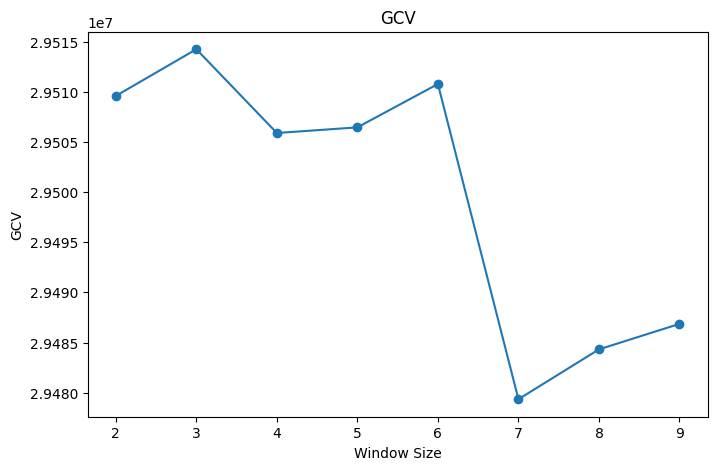

In [25]:
from utils.display import show_graph
gcv_scores = []
max_p = range(2,10,1)
for p in max_p:
    X, y_target = create_sliding_window(df.reshape(-1), p)
    gcv, model = gcv_linear_regression(X, y_target)
    gcv_scores.append(gcv)
optimal_window = max_p[np.argmin(gcv_scores)]
show_graph(max_p,gcv_scores,"GCV","Window Size","GCV")


## exercicio 4.2

In [ ]:
"""def create_sliding_windows(dataframe, seconds, overlap_ratio, sampling_rate):
    # 1. Configuração
    window_size = int(sampling_rate * seconds)
    step_size = int(window_size * (1 - overlap_ratio))
    
    if len(dataframe) < window_size:
        return pd.DataFrame()
    print(dataframe)
    data = dataframe.values
    cols = dataframe.columns.tolist()
    
    # 2. Identificar índices das colunas críticas para verificar "Pureza"
    # Queremos garantir que ATIVIDADE, PARTICIPANTE e DISPOSITIVO sejam constantes na janela
    print(cols)
    check_cols = ['actitivy_label', 'participant_id', 'device_id']
    check_idxs = [cols.index(c) for c in check_cols if c in cols]

    windows = []
    w_id = 0
    print(check_idxs)

    # 3. Loop Rápido
    for i in range(0, len(data) - window_size + 1, step_size):
        chunk = data[i : i + window_size]
        # --- FILTRO DE PUREZA ROBUSTO ---
        # Verifica se alguma das colunas de controlo (act, user, device) muda no meio da janela
        is_pure = True
        for idx in check_idxs:
            # Compara todos os valores com o primeiro valor da janela
            if not (chunk[:, idx] == chunk[0, idx]).all():
                is_pure = False
                break
        
        if not is_pure:
            continue

        # Adiciona ID e guarda
        ids = np.full((window_size, 1), w_id)
        windows.append(np.hstack((chunk, ids)))
        w_id += 1

    if not windows:
        return pd.DataFrame()

    # 4. Reconstrói DataFrame
    df = pd.DataFrame(np.vstack(windows), columns=cols + ['window_id']).infer_objects()

    # 5. Recria as colunas de Array (Listas)
    acc_cols = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    gyro_cols = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']
    mag_cols = ['magnetometer_x', 'magnetometer_y', 'magnetometer_z']
    
    if all(c in df.columns for c in acc_cols):
        df['acc_array'] = df[acc_cols].values.tolist()
    if all(c in df.columns for c in gyro_cols):
        df['gyro_array'] = df[gyro_cols].values.tolist()
    if all(c in df.columns for c in mag_cols):
        df['mag_array'] = df[mag_cols].values.tolist()
    if all(c in df.columns for c in acc_cols + gyro_cols):
        df['acc_gyro_array'] = df[acc_cols + gyro_cols].values.tolist()

    return df"""

In [3]:
import pandas as pd
import numpy as np

def detect_gaps(timestamps, gap_threshold):
    """
    Deteta intervalos onde a diferença entre amostras consecutivas excede o threshold.
    timestamps: numpy array de floats/ints (ordenado)
    gap_threshold: valor máximo permitido entre amostras
    Retorna: lista de tuplos (gap_start, gap_end)
    """
    # Calcula a diferença entre amostras consecutivas
    diffs = np.diff(timestamps)
    
    # Encontra índices onde a diferença é maior que o permitido
    gap_indices = np.where(diffs > gap_threshold)[0]
    
    gaps = []
    for idx in gap_indices:
        # O gap ocorre entre o elemento idx e o elemento idx+1
        start_gap = timestamps[idx]
        end_gap = timestamps[idx + 1]
        gaps.append((start_gap, end_gap))
        
    return gaps

def intersects_gap(win_start, win_end, gap_list):
    """
    Verifica se a janela [win_start, win_end) intersecta algum gap.
    """
    for g_start, g_end in gap_list:
        # Lógica de intersecção:
        # (StartGap < WinEnd) E (EndGap > WinStart)
        if g_start < win_end and g_end > win_start:
            return True
    return False

def create_sliding_windows(df, window_ms, step_ms, gap_threshold_ms=100):
    print("A preparar dados e detetar gaps...")
    
    # 1. Preparação Básica
    # Garantir ordenação (Crucial para searchsorted e diff)
    df = df.sort_values(by=["participant_id", "device_id", "timestamp"]).reset_index(drop=True)
    
    # Identificar colunas
    if 'activity_label' in df.columns: lbl_col = 'activity_label'
    elif 'actitivy_label' in df.columns: lbl_col = 'actitivy_label'
    else: lbl_col = 'activity'
    
    # Colunas de sensores para extrair
    sensor_cols = [c for c in df.columns if c not in 
                   ['participant_id', 'device_id', 'timestamp', 'datetime', 'grid_time', lbl_col, 'window_id']]

    # Estruturas de dados para o loop
    windows_data = []
    w_id_global = 0
    
    # 2. Iterar por Participante (Processamento Independente)
    for p_id, df_p in df.groupby("participant_id"):
        
        # Dicionários para acesso rápido aos dados deste participante
        # Chave: device_id -> Valor: (timestamps_array, labels_array, values_matrix)
        devices_data = {}
        device_gaps = {}
        device_bounds = []
        
        unique_devices = df_p['device_id'].unique()
        
        # --- PRÉ-PROCESSAMENTO DO PARTICIPANTE ---
        valid_participant = True
        
        for d_id in unique_devices:
            # Extrair dados do dispositivo
            df_d = df_p[df_p['device_id'] == d_id]
            ts = df_d['timestamp'].values
            
            if len(ts) == 0:
                valid_participant = False
                break
                
            # Detetar Gaps
            gaps = detect_gaps(ts, gap_threshold_ms)
            device_gaps[d_id] = gaps
            
            # Guardar dados em memória (numpy é mais rápido que pandas no loop)
            # Guardamos o DataFrame slice também para facilitar a extração final
            devices_data[d_id] = {
                'ts': ts,
                'lbl': df_d[lbl_col].values,
                'df_slice': df_d  # Mantemos o slice do pandas para extrair colunas depois
            }
            
            # Guardar limites (min, max)
            device_bounds.append((ts[0], ts[-1]))
            
        if not valid_participant or not device_bounds:
            continue
            
        # 3. CALCULAR JANELA DE OPERAÇÃO COMUM (Global Bounds)
        # O início global é o MAIOR dos inícios (todos têm de ter começado)
        start_global = max(b[0] for b in device_bounds)
        # O fim global é o MENOR dos fins (todos têm de estar ativos)
        end_global = min(b[1] for b in device_bounds)
        
        # Se a janela útil for menor que o tamanho da janela, ignorar participante
        if (end_global - start_global) < window_ms:
            continue
            
        # 4. LOOP DE GERAÇÃO DE JANELAS
        curr_time = start_global
        
        while curr_time + window_ms <= end_global:
            win_start = curr_time
            win_end = curr_time + window_ms
            
            window_is_valid = True
            temp_window_chunks = [] # Para armazenar os dados se a janela for válida
            
            # Validar contra TODOS os dispositivos
            for d_id in unique_devices:
                # A. Checar Gaps
                if intersects_gap(win_start, win_end, device_gaps[d_id]):
                    window_is_valid = False
                    break
                
                # B. Obter Índices (SearchSorted é O(log N) - Muito Rápido)
                ts_arr = devices_data[d_id]['ts']
                # Encontrar onde começa e onde acaba a janela neste array
                idx_start = np.searchsorted(ts_arr, win_start, side='left')
                idx_end = np.searchsorted(ts_arr, win_end, side='left')
                
                # C. Validar se existem dados suficientes (opcional mas recomendado)
                # Se searchsorted devolver o mesmo índice, não há dados no intervalo
                if idx_start == idx_end:
                    window_is_valid = False
                    break
                    
                # D. Checar Pureza da Label
                lbl_arr = devices_data[d_id]['lbl']
                labels_in_window = lbl_arr[idx_start:idx_end]
                
                # np.unique é rápido. Se len > 1, tem labels misturadas.
                if len(np.unique(labels_in_window)) > 1:
                    window_is_valid = False
                    break
                
                # Se passou tudo, preparar o chunk
                # Pegamos o slice do DataFrame original usando iloc relativo
                df_slice = devices_data[d_id]['df_slice'].iloc[idx_start:idx_end].copy()
                temp_window_chunks.append(df_slice)
            
            # SE A JANELA FOR VÁLIDA EM TODOS OS DEVICES
            if window_is_valid:
                # Concatenar todos os chunks desta janela
                # (Eles ficam empilhados verticalmente, como tinhas no original)
                win_df = pd.concat(temp_window_chunks)
                win_df['window_id'] = w_id_global
                windows_data.append(win_df)
                
                w_id_global += 1
            
            # Avançar no tempo
            curr_time += step_ms

    print(f"Processamento concluído. {len(windows_data)} janelas geradas.")
    
    if not windows_data:
        return pd.DataFrame()

    # 5. RECONSTRUÇÃO FINAL
    final_df = pd.concat(windows_data, ignore_index=True)
    
    # Recriação das Colunas de Array (Listas) para TSFresh
    acc_cols = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    gyro_cols = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']
    mag_cols = ['magnetometer_x', 'magnetometer_y', 'magnetometer_z']
    
    # Verifica quais colunas existem e cria as listas
    if all(c in final_df.columns for c in acc_cols):
        final_df['acc_array'] = final_df[acc_cols].values.tolist()
    if all(c in final_df.columns for c in gyro_cols):
        final_df['gyro_array'] = final_df[gyro_cols].values.tolist()
    if all(c in final_df.columns for c in mag_cols):
        final_df['mag_array'] = final_df[mag_cols].values.tolist()
    if all(c in final_df.columns for c in acc_cols + gyro_cols):
        final_df['acc_gyro_array'] = final_df[acc_cols + gyro_cols].values.tolist()

    return final_df

In [2]:
import pandas as pd
import tsfresh
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators
from tsfresh.utilities.string_manipulation import convert_to_output_format
import numpy as np
from config.constants import ACC_ARRAY_COLUMN, ACC_GYRO_COLUMN, COLUMNS_ACCELEROMETER, COLUMNS_GYROSCOPE, COLUMNS_MAGNETOMETER,DEVICES, GYRO_ARRAY_COLUMN
from tsfresh import extract_features


################################Physicial features#######################################
# =============================================================================
# 1. INTENSIDADE DE MOVIMENTO (MI)
# =============================================================================
@set_property("fctype", "combiner")
def mi_intensity(acc_array,param):
    arr = np.vstack(acc_array).astype(float)  # transforma em shape (N,3)
    magn = np.linalg.norm(arr, axis=1)
    avg_intensity = float(np.mean(magn)) if magn.size else 0.0
    variance_intensity = float(np.var(magn)) if magn.size else 0.0
    return [("avg",avg_intensity),("var",variance_intensity)]

# =============================================================================
# 2. SMA (Signal Magnitude Area)
# =============================================================================

@set_property("fctype", "simple")
def sma(acc_array):
    arr = np.vstack(acc_array).astype(float)
    sma_vals = np.sum(np.abs(arr), axis=1)
    return float(np.mean(sma_vals)) if sma_vals.size else 0.0


# =============================================================================
# 3. VALORES PRÓPRIOS EVA
# =============================================================================
@set_property("fctype", "combiner")
def EVA(acc_array,param):
    arr = np.vstack(acc_array).astype(float)
    if arr.shape[0] < 2:
        return [("ver", 0.0),("head", 0.0)]
    cov = np.cov(arr, rowvar=False)
    vals = np.linalg.eigvalsh(cov)
    vals_sorted = np.sort(vals)
    return [("ver", float(vals_sorted[0])), ("head", float(vals_sorted[-1]))]


# =============================================================================
# 4. CAGH – Correlação gravidade (aprox eixo X) × heading (norma YZ)
# =============================================================================

@set_property("fctype", "simple")
def cagh(acc_array):
    arr = np.vstack(acc_array).astype(float)
    if arr.shape[1] < 3:
        return 0.0
    ax = arr[:, 0]              # direção da gravidade
    heading = np.linalg.norm(arr[:, 1:3], axis=1)
    if len(heading) < 2:
        return 0.0
    # derivada discreta da heading
    heading_deriv = np.diff(heading)
    ax_trunc = ax[1:]
    if np.std(ax_trunc) == 0 or np.std(heading_deriv) == 0:
        return 0.0
    return float(np.corrcoef(ax_trunc, heading_deriv)[0, 1])


# =============================================================================
# 5. AVH – Velocidade média ao longo da direção de avanço (heading)
# =============================================================================

@set_property("fctype", "simple")
def avh(acc_array):
    arr = np.vstack(acc_array).astype(float)
    if arr.shape[1] < 3:
        return 0.0
    heading_acc = np.linalg.norm(arr[:, 1:3], axis=1)
    # integração sem dt → acumulado discreto (unidades arbitrárias)
    velocity = np.cumsum(heading_acc)

    return float(np.mean(np.abs(velocity))) if velocity.size else 0.0


# =============================================================================
# 6. AVG – Velocidade média ao longo da direção da gravidade (aprox eixo X)
# =============================================================================

@set_property("fctype", "simple")
def avg(acc_array):
    arr = np.vstack(acc_array).astype(float)
    ax = arr[:, 0]
    velocity = np.cumsum(ax)
    return float(np.mean(np.abs(velocity))) if velocity.size else 0.0


# =============================================================================
# 7. ARATG – Ângulos médios de rotação (usa gyro_x como rotação no eixo gravidade)
# =============================================================================

@set_property("fctype", "simple")
def aratg(gyro_array):
    arr = np.vstack(gyro_array).astype(float)
    gx = arr[:, 0]  # rotação em torno da gravidade
    angle_increment = np.abs(gx)  # sem dt → soma discreta
    return float(np.mean(angle_increment)) if angle_increment.size else 0.0


# =============================================================================
# 8. DF – Dominant Frequency (por eixo individual)
# =============================================================================

@set_property("fctype", "simple")
def dominant_frequency_axis(signal_1d):
    arr = np.asarray(signal_1d, dtype=float)
    if arr.size < 2:
        return 0.0
    arr = arr - np.mean(arr)
    fft_vals = np.fft.rfft(arr)
    power = np.abs(fft_vals)**2
    power[0] = 0  # excluir DC
    idx = np.argmax(power)
    return float(idx)  # índice do pico (freq ≈ idx se dt=1)


# =============================================================================
# 9. ENERGY – Energia por eixo
# =============================================================================

@set_property("fctype", "simple")
def energy_axis(signal_1d):
    s = np.asarray(signal_1d, dtype=float)
    if s.size < 2:
        return 0.0
    s = s - np.mean(s)
    fft_vals = np.fft.rfft(s)
    power = np.abs(fft_vals)**2
    power[0] = 0
    return float(np.sum(power))


# =============================================================================
# 10. AAE – Energia média dos 3 eixos do acelerómetro
# =============================================================================

@set_property("fctype", "simple")
def aae(acc_array):
    arr = np.vstack(acc_array).astype(float)
    energy = np.sum(arr**2, axis=1)  # ax² + ay² + az²
    return float(np.mean(energy)) if energy.size else 0.0


# =============================================================================
# 11. ARE – Energia média dos 3 eixos do giroscópio
# =============================================================================
@set_property("fctype", "simple")
def are(gyro_array):
    arr = np.vstack(gyro_array).astype(float)
    energy = np.sum(arr**2, axis=1)

    return float(np.mean(energy)) if energy.size else 0.0

#####################Features estatisticas######################################

@set_property("fctype", "simple")
def mean_crossing_rate(x):
    """
    Número de cruzamentos da série com a sua média (Mean Crossing Rate).
    """
    arr = np.asarray(x, dtype=float)
    mean_val = np.mean(arr)
    # vetor booleano indicando se cada ponto está acima ou abaixo da média
    above = arr > mean_val
    # cruzamentos acontecem quando o estado muda de True → False ou False → True
    crossings = np.sum(above[:-1] != above[1:])
    return int(crossings)


@set_property("fctype", "simple")
def spectral_entropy(x: pd.Series) -> float:
    y = np.array(x, dtype=float) 
    y = y - y.mean()
    psd = np.abs(np.fft.rfft(y)) ** 2
    psd_sum = psd.sum()
    if psd_sum == 0:
        return 0.0
    p = psd / psd_sum
    p = p[p > 0]
    se = -np.sum(p * np.log2(p))
    return float(se / np.log2(len(psd)))
@set_property("fctype", "simple")
def interq_range(x):
    """
    Amplitude Interquartil (IQR = P75 - P25)
    """
    arr = np.asarray(x, dtype=float)

    if arr.size == 0:
        return 0.0

    q75 = np.percentile(arr, 75)
    q25 = np.percentile(arr, 25)
    return float(q75 - q25)


@set_property("fctype", "simple")
def averaged_derivative(x: pd.Series,**kwargs) -> float:
    """
    Derivada média absoluta de um sinal 1D.
    Usada em reconhecimento de fala e escrita.
    """
    arr = np.asarray(x, dtype=float)

    if arr.size < 2:
        return 0.0

    # primeira derivada: |x[i] - x[i-1]|
    derivative = np.abs(np.diff(arr))

    return float(np.mean(derivative))



@set_property("fctype", "combiner")
def pairwise_correlation(x, param):
    arr = np.array(x.tolist())  # N x 6
    acc = arr[:, :3]
    gyro = arr[:, 3:]
    
    features = []
    
    # Acc interno
    corr_acc = np.corrcoef(acc, rowvar=False)
    features.append(('corr_acc_xy', corr_acc[0,1]))
    features.append(('corr_acc_xz', corr_acc[0,2]))
    features.append(('corr_acc_yz', corr_acc[1,2]))
    
    # Gyro interno
    corr_gyro = np.corrcoef(gyro, rowvar=False)
    features.append(('corr_gyro_xy', corr_gyro[0,1]))
    features.append(('corr_gyro_xz', corr_gyro[0,2]))
    features.append(('corr_gyro_yz', corr_gyro[1,2]))
    
    # Acc vs Gyro
    axes = ["x","y","z"]
    for i, a in enumerate(axes):
        for j, g in enumerate(axes):
            features.append((f'acc_{a}_gyro_{g}', np.corrcoef(acc[:,i], gyro[:,j])[0,1]))    
    return [(name, val) for name,val in features]



setattr(tsfresh.feature_extraction.feature_calculators, 'mean_crossing_rate', mean_crossing_rate)
setattr(tsfresh.feature_extraction.feature_calculators, 'averaged_derivative', averaged_derivative)
setattr(tsfresh.feature_extraction.feature_calculators, 'spectral_entropy', spectral_entropy)
setattr(tsfresh.feature_extraction.feature_calculators,"pairwise_correlation",pairwise_correlation)
setattr(tsfresh.feature_extraction.feature_calculators,"interq_range",interq_range)

setattr(tsfresh.feature_extraction.feature_calculators,"mi_intensity", mi_intensity)
setattr(tsfresh.feature_extraction.feature_calculators,"sma", sma)
setattr(tsfresh.feature_extraction.feature_calculators,"EVA", EVA)
setattr(tsfresh.feature_extraction.feature_calculators,"cagh",cagh)
setattr(tsfresh.feature_extraction.feature_calculators,"avh",avh)
setattr(tsfresh.feature_extraction.feature_calculators,"aae",aae)
setattr(tsfresh.feature_extraction.feature_calculators,"avg",avg)
setattr(tsfresh.feature_extraction.feature_calculators,"aratg",aratg)
setattr(tsfresh.feature_extraction.feature_calculators,"are",are)
setattr(tsfresh.feature_extraction.feature_calculators,"dominant_frequency_axis",dominant_frequency_axis)
setattr(tsfresh.feature_extraction.feature_calculators,"energy_axis",energy_axis)






def to_long_format(df, label_col='actitivy_label'):
    df = df.copy()

    # 1. Criar o ID Único (User_Device_Window)
    # Convertemos para int->str para garantir formato limpo "14_1_0"
    p_str = df['participant_id'].astype(float).astype(int).astype(str)
    d_str = df['device_id'].astype(float).astype(int).astype(str)
    w_str = df['window_id'].astype(float).astype(int).astype(str)
    
    df['id'] = p_str + "_" + d_str + "_" + w_str

    # 2. Extrair o Mapeamento de Labels (ID -> Activity)
    # Como assumimos que a janela é pura, basta pegar a primeira linha de cada ID
    labels_map = df.drop_duplicates(subset=['id']).set_index('id')[label_col]

    # 3. Criar Eixo do Tempo (0, 1, 2... N dentro da janela)
    df['time'] = df.groupby('id').cumcount()

    # 4. Transformar em Long Format (Melt)
    vars_to_melt = (
        COLUMNS_ACCELEROMETER + 
        COLUMNS_GYROSCOPE + 
        COLUMNS_MAGNETOMETER + 
        [ACC_GYRO_COLUMN, ACC_ARRAY_COLUMN, GYRO_ARRAY_COLUMN]
    )
    
    # Filtra apenas as colunas que realmente existem no df
    vars_present = [v for v in vars_to_melt if v in df.columns]

    long_df = df.melt(
        id_vars=['id', 'time'],
        value_vars=vars_present,
        var_name='kind',
        value_name='value'
    )
    
    # Retorna o DataFrame Longo E o Mapa de Labels
    return long_df, labels_map


def df_to_tsfresh_format(df):
    long_df = pd.DataFrame()
    
    for col in df.columns:
        if col in ["window_id", "time", "device_id", "id","participant_id"]:
            continue
        
        tmp = pd.DataFrame({
            "id": df["id"],
            "time": df["time"],
            "kind": col,  # acc_x, acc_y, etc.
            "value": df[col]
        })
        
        long_df = pd.concat([long_df, tmp], ignore_index=True)

    return long_df


def extract_features_sensors(dataframe, window_size, step_size):
    # 1) Criar janelas
    print("starting")
    df_windowed = create_sliding_windows(
    df=dataframe, 
    window_ms=window_size,           # Quero 2 segundos
    step_ms=step_size   # 50% de sobreposição
)

   
    df = df_windowed[
        COLUMNS_ACCELEROMETER +
        COLUMNS_GYROSCOPE +
        COLUMNS_MAGNETOMETER +
        ["device_id","window_id","participant_id","actitivy_label", ACC_GYRO_COLUMN, ACC_ARRAY_COLUMN, GYRO_ARRAY_COLUMN]
    ]
    long_df,labels = to_long_format(df)
    

    stat_features = {
        "mean": None,
        "median": None,
        "standard_deviation": None,
        "variance": None,
        "root_mean_square": None,
        "skewness": None,
        "kurtosis": None,
        "number_crossing_m": [{"m": 0}],   # zero-crossing
        "mean_crossing_rate": None,
        "averaged_derivative": None,
        "spectral_entropy": None,
        "interq_range": None,
    }

    # aplicar estatísticas a todos os eixos individuais
    kind_to_fc_parameters = {k: stat_features.copy()
                             for k in COLUMNS_ACCELEROMETER + COLUMNS_GYROSCOPE}

    # features combinadas acc+gyro
    kind_to_fc_parameters[ACC_GYRO_COLUMN] = {
        "pairwise_correlation": None
    }

    # ---------------------------------------------------------
    # 5. FEATURE SET – FÍSICAS
    # ---------------------------------------------------------
    physical_features = {
        "dominant_frequency_axis": None,
        "energy_axis": None
    }

    # adicionar físicas aos eixos individuais
    for k in COLUMNS_ACCELEROMETER + COLUMNS_GYROSCOPE:
        kind_to_fc_parameters[k].update(physical_features)

    # 5.1 — features específicas para acc_array (3D)
    kind_to_fc_parameters[ACC_ARRAY_COLUMN] = {
        "mi_intensity": None,
        "sma": None,
        "EVA": None,
        "cagh": None,
        "avh": None,
        "aae": None,
    }

    # 5.2 — gyroscope_x recebe AVG
    if "gyroscope_x" in kind_to_fc_parameters:
        kind_to_fc_parameters["gyroscope_x"].update({"avg": None})

    # 5.3 — gyro_array recebe ARE e ARATG
    kind_to_fc_parameters[GYRO_ARRAY_COLUMN] = {
        "aratg": None,
        "are": None
    }

    # ---------------------------------------------------------
    # 6. EXTRAÇÃO FINAL DE FEATURES
    # ---------------------------------------------------------
    print("Extracting features...")
    features = extract_features(
        long_df,
        column_id="id",
        column_sort="time",
        column_kind="kind",
        column_value="value",
        kind_to_fc_parameters=kind_to_fc_parameters,
        n_jobs=0
    )
    features['activity'] = labels
    return features

In [7]:
features = extract_features_sensors(dataset,2000, 1000)
#features.to_csv('550features.csv')

starting
A preparar dados e detetar gaps...
Processamento concluído. 12337 janelas geradas.
Extracting features...


Feature Extraction: 100%|██████████| 740220/740220 [21:49<00:00, 565.20it/s]


In [8]:
features.to_csv('550features.csv')

In [14]:
features.shape

(61685, 111)

In [ ]:
pd.to_

In [ ]:
import pandas as pd
features=pd.read_csv('550features.csv')
features.shape  

#normalize

(78466, 111)

In [12]:
def create_clean_database(features):
    df_final = features.copy()

    # 1. DETETAR A ORIGEM DO ID
    # No teu print, o ID está numa coluna chamada "Unnamed: 0"
    if 'Unnamed: 0' in df_final.columns:
        # Pega na coluna e converte para string
        id_source = df_final['Unnamed: 0'].astype(str)
        # Remove a coluna original para não duplicar
        df_final.drop(columns=['Unnamed: 0'], inplace=True)
    else:
        # Se não houver coluna, usa o index
        id_source = df_final.index.to_series().astype(str)

    # 2. FAZER O SPLIT
    # O expand=True cria logo 3 colunas
    ids_split = id_source.str.split('_', expand=True)

    # 3. INSERIR E CONVERTER TIPOS
    # Usamos pd.to_numeric para garantir que "0.0" vira o número 0 corretamente
    
    # Participante (Coluna 0 do split)
    df_final.insert(0, 'participant_id', pd.to_numeric(ids_split[0]).astype(int))
    
    # Device (Coluna 1 do split)
    df_final.insert(1, 'device_id', pd.to_numeric(ids_split[1]).astype(int))
    
    # Window (Coluna 2 do split)
    df_final.insert(2, 'window_id', pd.to_numeric(ids_split[2]).astype(int))
    
    # 4. Resetar o index para ficar limpo (0, 1, 2...)
    df_final = df_final.reset_index(drop=True)
    
    return df_final

# --- Como usar ---
# df_clean = create_clean_database(features)
# print(df_clean[['participant_id', 'device_id', 'window_id']].head())

df_clean = create_clean_database(features)


In [19]:
df_clean

,participant_id,device_id,window_id,acc_array__mi_intensity__avg,acc_array__mi_intensity__var,acc_array__sma,acc_array__EVA__ver,acc_array__EVA__head,acc_array__cagh,acc_array__avh,...,gyroscope_z__skewness,gyroscope_z__kurtosis,gyroscope_z__number_crossing_m__m_0,gyroscope_z__mean_crossing_rate,gyroscope_z__averaged_derivative,gyroscope_z__spectral_entropy,gyroscope_z__interq_range,gyroscope_z__dominant_frequency_axis,gyroscope_z__energy_axis,activity
0,0,1,0,9.856750,0.004567,13.777994,0.003473,0.019010,0.102735,504.287498,...,-2.474193,7.210858,9.0,14.0,0.383831,0.557645,0.955589,2.0,12688.489577,1.0
1,0,1,1,9.857157,0.002807,13.637085,0.001845,0.033516,-0.014952,499.636495,...,0.156871,-0.594463,10.0,15.0,0.246919,0.592516,0.826748,3.0,1841.702593,1.0
2,0,1,10,9.857010,0.001423,13.305857,0.001415,0.023781,-0.124542,505.932343,...,-0.221671,1.158934,11.0,27.0,0.232193,0.699158,0.585440,4.0,1259.460953,1.0
3,0,1,100,9.988363,0.000162,12.862857,0.000126,0.001813,0.290978,513.816280,...,-1.447565,2.469458,6.0,28.0,0.125995,0.599602,0.193705,2.0,268.911557,2.0
4,0,1,101,9.988850,0.000179,12.885230,0.000155,0.002545,0.290387,518.800157,...,-1.108865,1.534282,6.0,26.0,0.134785,0.603689,0.265060,1.0,302.752427,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61680,9,5,7844,9.754886,0.000126,11.174989,0.000107,0.000333,0.128961,504.187188,...,0.168829,-0.204870,0.0,36.0,0.107366,0.782343,0.199365,2.0,105.375778,1.0
61681,9,5,7845,9.754818,0.000132,11.181032,0.000125,0.000602,0.146946,504.148021,...,-0.400216,-0.251023,0.0,32.0,0.109478,0.753394,0.228805,1.0,131.648792,1.0
61682,9,5,7846,9.754659,0.000142,11.207169,0.000141,0.000823,-0.013439,499.217852,...,0.040695,-0.585660,0.0,25.0,0.120357,0.391340,0.370922,1.0,364.350412,1.0
61683,9,5,7847,9.754006,0.000137,11.174136,0.000124,0.001929,-0.002516,499.239308,...,-0.581818,-0.510764,0.0,12.0,0.131434,0.477390,0.406142,1.0,495.290095,1.0


In [20]:
import pandas as pd

def reshape_features_robust(df_clean):
    df_clean = df_clean.copy()
    
    # 1. TRATAMENTO DE TIPOS E SORTING
    try:
        df_clean['participant_id'] = df_clean['participant_id'].astype(float).astype(int)
        df_clean['device_id'] = df_clean['device_id'].astype(float).astype(int)
        df_clean['window_id'] = df_clean['window_id'].astype(float).astype(int)
    except Exception as e:
        print(f"Aviso tipos: {e}")

    df_clean = df_clean.sort_values(by=['participant_id', 'device_id', 'window_id'])

    # 2. DETETAR COLUNA DE LABEL
    # Verifica qual o nome correto da coluna
    if 'activity_label' in df_clean.columns: 
        lbl_col = 'activity_label'
    elif 'activity' in df_clean.columns: 
        lbl_col = 'activity'
    elif 'actitivy_label' in df_clean.columns: # Caso haja typo antigo
        lbl_col = 'actitivy_label'
    else:
        print("ERRO: Coluna de atividade não encontrada!")
        return None

    # 3. CRIAR ID ALINHADO
    # Nota: Isto só funciona bem porque garantimos antes que todos os devices têm o mesmo nº de janelas
    df_clean['aligned_window_id'] = df_clean.groupby(['participant_id', 'device_id']).cumcount()
    
    # --- O FIX: GUARDAR AS LABELS ANTES DO PIVOT ---
    # Agrupamos por Participante e Janela e pegamos na primeira label que encontrarmos
    # (Como a janela é pura, a label é igual para o device 1, 2, 3...)
    y_labels = df_clean.groupby(['participant_id', 'aligned_window_id'])[lbl_col].first()
    
    # 4. PREPARAR PIVOT (Apenas features numéricas)
    cols_to_ignore = ['participant_id', 'window_id', 'device_id', lbl_col, 'id', 'Unnamed: 0', 'aligned_window_id']
    feature_cols = [c for c in df_clean.columns if c not in cols_to_ignore]
    
    # 5. PIVOT
    df_wide = df_clean.pivot(
        index=['participant_id', 'aligned_window_id'], 
        columns='device_id', 
        values=feature_cols
    )
    
    # 6. ACHATAR NOMES DAS COLUNAS (Flatten)
    # Transforma (mean_x, 1) em "S1_mean_x"
    df_wide.columns = [f"S{int(dev)}_{feat}" for feat, dev in df_wide.columns]
    
    # --- O FIX: JUNTAR AS LABELS DE VOLTA ---
    # O join funciona automaticamente porque o index (participant, aligned_window) é igual nos dois
    df_wide = df_wide.join(y_labels)
    
    # 7. FINALIZAÇÃO
    df_wide = df_wide.reset_index()
    df_wide.rename(columns={'aligned_window_id': 'window_id'}, inplace=True)
    
    return df_wide

# Testar
X_final_550 = reshape_features_robust(df_clean)
print(f"Shape Final Obtido: {X_final_550.shape}")

# Verificar se a coluna existe
if 'activity_label' in X_final_550.columns:
    print("Sucesso: A coluna 'activity_label' está presente!")
    print(X_final_550[['participant_id', 'window_id', 'activity_label']].head())


Shape Final Obtido: (12337, 553)


In [21]:
X_final_550

,participant_id,window_id,S1_acc_array__mi_intensity__avg,S2_acc_array__mi_intensity__avg,S3_acc_array__mi_intensity__avg,S4_acc_array__mi_intensity__avg,S5_acc_array__mi_intensity__avg,S1_acc_array__mi_intensity__var,S2_acc_array__mi_intensity__var,S3_acc_array__mi_intensity__var,...,S2_gyroscope_z__dominant_frequency_axis,S3_gyroscope_z__dominant_frequency_axis,S4_gyroscope_z__dominant_frequency_axis,S5_gyroscope_z__dominant_frequency_axis,S1_gyroscope_z__energy_axis,S2_gyroscope_z__energy_axis,S3_gyroscope_z__energy_axis,S4_gyroscope_z__energy_axis,S5_gyroscope_z__energy_axis,activity
0,0,0,9.856750,9.991888,9.974768,9.892278,9.715958,0.004567,0.006963,0.007639,...,1.0,1.0,11.0,1.0,12688.489577,45210.953368,1172.978105,172.202170,543.001905,1.0
1,0,1,9.857157,9.993901,9.982564,9.890450,9.716196,0.002807,0.012240,0.008632,...,1.0,2.0,3.0,2.0,1841.702593,44916.829939,2226.996986,370.849127,499.419334,1.0
2,0,2,9.858970,9.994875,9.978742,9.890464,9.715584,0.001664,0.008862,0.006189,...,1.0,1.0,1.0,3.0,1753.146778,7799.500965,3393.130060,383.356693,385.526188,1.0
3,0,3,9.855671,9.991575,9.971591,9.892040,9.716208,0.004343,0.002620,0.004723,...,1.0,1.0,1.0,3.0,4051.039389,4212.726086,2439.348615,516.271851,1033.910084,1.0
4,0,4,9.852071,9.993685,9.968388,9.890004,9.717383,0.005955,0.003962,0.005171,...,3.0,1.0,1.0,2.0,10432.953905,963.312659,2693.669687,609.344273,1110.988433,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12332,14,924,9.838935,10.081947,9.856391,9.900840,9.754173,0.001049,0.001416,0.003176,...,3.0,1.0,1.0,2.0,1561.728504,3263.515404,1460.309127,156.808207,205.350755,1.0
12333,14,925,9.839966,10.080149,9.859811,9.899031,9.753445,0.000794,0.001171,0.004338,...,4.0,1.0,11.0,1.0,1824.021353,1856.618053,1226.930560,142.849650,222.411652,1.0
12334,14,926,9.835742,10.078700,9.857174,9.897962,9.755707,0.000711,0.000934,0.004070,...,1.0,1.0,1.0,1.0,1997.625061,2016.851828,714.565713,233.989469,369.525928,1.0
12335,14,927,9.834805,10.082226,9.857963,9.896911,9.756074,0.000587,0.000713,0.003826,...,1.0,1.0,1.0,1.0,1473.266157,1586.308863,1495.816378,231.214835,407.477616,1.0


In [ ]:
X_final_550.to_csv('X_final_550.csv')

# Meta B

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import load_iris
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, Markdown

%load_ext autoreload
%autoreload 2


import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


from experiments.experiment import Experiment
data = load_iris()
X, y = data.data, data.target
#########BASE LINE############
models = {
    "Random": DummyClassifier(),
    "OneR": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier()
}
model_parameters = {
    "Random": {"strategy": ["most_frequent"]},
    "OneR": {"max_depth": [1]},
    "kNN": {"n_neighbors": [1]}
}

exp = Experiment(X, y, models, model_parameters)

experiments,cms,cm_total = exp.run_train_only()
display(Markdown("## Exercise 2.1"))

display(Markdown("### Train-only"))
display(experiments)

experiments,cms,cm_total = exp.run_train_test()
display(Markdown("### Train-Test 70-30"))
display(experiments)


experiments,cms,cm_total = exp.run_cross_validation(n_splits=10)
display(Markdown("### 10x10-fold cross-validation"))
display(experiments)


## Exercise 2.1

### Train-only

,Model,strategy,Accuracy,Recall,Precision,F1,max_depth,n_neighbors
0,Random,most_frequent,0.333333,0.333333,0.111111,0.166667,NaN,NaN
1,OneR,NaN,0.666667,0.666667,0.500000,0.555556,1.0,NaN
2,kNN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,1.0


### Train-Test 70-30

,Model,strategy,Accuracy,Recall,Precision,F1,max_depth,n_neighbors
0,Random,most_frequent,0.333333,0.333333,0.111111,0.166667,NaN,NaN
1,OneR,NaN,0.666667,0.666667,0.500000,0.555556,1.0,NaN
2,kNN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,1.0


### 10x10-fold cross-validation

,Model,strategy,Acc_Mean,Acc_Std,Prec_Mean,Prec_Std,Rec_Mean,Rec_Std,F1_Mean,F1_Std,max_depth,n_neighbors
0,Random,most_frequent,0.222667,0.066145,0.053956,0.027064,0.222667,0.066145,0.086133,0.040052,NaN,NaN
1,OneR,NaN,0.598667,0.083788,0.443469,0.103944,0.598667,0.083788,0.488032,0.099232,1.0,NaN
2,kNN,NaN,0.959333,0.049795,0.965562,0.043645,0.959333,0.049795,0.959340,0.049476,NaN,1.0


In [41]:
dataset.columns

Index(['device_id', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
       'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'magnetometer_x',
       'magnetometer_y', 'magnetometer_z', 'timestamp', 'actitivy_label',
       'participant_id', 'magnetometer_module', 'gyroscope_module',
       'accelerometer_module'],
      dtype='object')

In [41]:

models = {
    "kNN": KNeighborsClassifier()
}
model_parameters = {
    "kNN": {"n_neighbors": [1]}
}
exp = Experiment(X, y, models, model_parameters)

experiments,cms,cm_total = exp.run_train_only()
display(Markdown("## Exercise 2.2"))
display(Markdown("### Exercise 2.2.1"))
display(Markdown("#### Train-only"))
display(experiments)

experiments,cms,cm_total = exp.run_train_test()
display(Markdown("#### Train-Test 70-30"))
display(experiments)


experiments,cms,cm_total = exp.run_cross_validation(n_splits=10)
display(Markdown("#### 10x10-fold cross-validation"))
display(experiments)

#################################################
################Exercise 2.2.2###################
#################################################

models = {
    "kNN": KNeighborsClassifier()
}
model_parameters = {
    "kNN": {"n_neighbors": list(range(1, 16, 2))}###até 15
}
exp = Experiment(X, y, models, model_parameters)
experiments,cms,cm_total = exp.run_train_only()

display(Markdown("### Exercise 2.2.2"))
display(Markdown("#### Train-only"))
display(experiments)

experiments,cms,cm_total = exp.run_train_test()
display(Markdown("#### Train-Test 70-30"))
display(experiments)

validation,results,cms = exp.run_train_test_validation(val_size=0.2,test_size=0.2)
display(Markdown("#### Train-Test-Validation 60-20-20"))
display(results)


experiments,cms,cm_total = exp.run_cross_validation(n_splits=10)
display(Markdown("#### 10x10-fold cross-validation"))
display(experiments)



## Exercise 2.2

### Exercise 2.2.1

#### Train-only

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Train-Test 70-30

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### 10x10-fold cross-validation

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


### Exercise 2.2.2

#### Train-only

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Train-Test 70-30

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### Train-Test-Validation 60-20-20

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


#### 10x10-fold cross-validation

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [48]:
models = {
    "kNN": KNeighborsClassifier()
}
model_parameters = {
    "kNN": {"n_neighbors": list(range(1, 16, 2))}###até 15
}
exp = Experiment(X, y, models, model_parameters)
tests,results,cms = exp.run_train_test_validation(val_size=0.2,test_size=0.2)
tests


Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [ ]:

from sklearn.ensemble import RandomForestClassifier
models = {
    "kNN": KNeighborsClassifier(),
    "RF": RandomForestClassifier()
}
model_parameters = {
    "kNN": {"n_neighbors": [1,3,5,7,9,11,13,15]},
    "RF": {"n_estimators": [1,3,5,7,9,11,13,15]}
}

    
exp = Experiment(X, y, models, model_parameters)
experiment_results=exp.run_cross_with_validation_feature_selection(number_of_folds=10,n_repeats=10,test_size=0.3)




[Repetição 1/10]
  > Fold 1/10
  > Fold 2/10


KeyboardInterrupt: 

In [34]:
experiment_results

NameError: name 'experiment_results' is not defined

In [ ]:
import pandas as pd
import numpy as np
import re  

registos = []
cm_totais = {} 

for entry in experiment_results:
    repetition = entry['repetition']
    fold_id = entry['fold_id']
    
    for model_data in entry['models']:
        metrics = model_data['test_metrics']
        model_name = model_data['model_name']
        
        # --- 1. Extração das Métricas ---
        row = {
            'Repetition': repetition,
            'Fold': fold_id,
            'Model': model_name,
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1': metrics['F1']
        }
        registos.append(row)
        
        # --- 2. Extração Robusta da CM usando Regex ---
        raw_data = model_data['test_confusion_matrix']
        
        # Se já for um array numpy ou lista, usa diretamente
        if isinstance(raw_data, (np.ndarray, list)):
            current_cm = np.array(raw_data)
        else:
            # Se for string, usa regex para encontrar todos os números inteiros
            # r'\d+' encontra sequências de dígitos ignorando tudo o resto
            numeros = re.findall(r'\d+', str(raw_data))
            
            if numeros:
                # Converte lista de strings numéricas para inteiros
                flat_data = [int(x) for x in numeros]
                # Calcula o tamanho da dimensão (raiz quadrada do total de elementos)
                # Ex: 9 elementos -> raiz 3 -> matriz 3x3
                dim = int(len(flat_data)**0.5)
                current_cm = np.array(flat_data).reshape(dim, dim)
            else:
                current_cm = np.zeros((3, 3)) # Fallback se não achar números

        # Soma acumulativa por modelo
        if model_name not in cm_totais:
            cm_totais[model_name] = current_cm
        else:
            cm_totais[model_name] += current_cm

# 3. DataFrame e Métricas
df = pd.DataFrame(registos)
estimativas = df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].agg(['mean', 'std'])

# 4. Apresentar Resultados
print("--- Métricas Agregadas ---")
display(estimativas)

print("\n--- Matrizes de Confusão Acumuladas (Soma Total) ---")
for model, cm in cm_totais.items():
    print(f"\nModelo: {model}")
    # Cria DataFrame para visualização limpa
    df_cm = pd.DataFrame(cm, 
                         index=[f'Real {i}' for i in range(cm.shape[0])], 
                         columns=[f'Pred {i}' for i in range(cm.shape[1])])
    display(df_cm)

--- Métricas Agregadas ---


Accuracy           Precision              Recall                  F1  \
           mean       std      mean       std      mean       std      mean   
Model                                                                         
RF     0.949333  0.049346  0.956584  0.048035  0.949333  0.049346  0.947973   
kNN    0.952000  0.052826  0.958561  0.048719  0.952000  0.052826  0.950848   

                 
            std  
Model            
RF     0.052000  
kNN    0.054746


--- Matrizes de Confusão Acumuladas (Soma Total) ---

Modelo: kNN


,Pred 0,Pred 1,Pred 2
Real 0,500,0,0
Real 1,0,470,30
Real 2,0,42,458



Modelo: RF


,Pred 0,Pred 1,Pred 2
Real 0,500,0,0
Real 1,0,471,29
Real 2,0,47,453


In [ ]:
exp = Experiment(X, y, models, model_parameters)
exp.run_train_test_validation(val_size=0.2, test_size=0.2)

(  Model         Best_Params  Validation_Best_Score  Accuracy    Recall  \
 0   kNN  {'n_neighbors': 1}               0.937322  0.944444  0.944444   
 
    Precision        F1  
 0   0.952381  0.937322  ,
   Model               Params  n_neighbors  Validation_Score  Val_Accuracy  \
 0   kNN   {'n_neighbors': 1}            1          0.937322      0.944444   
 1   kNN   {'n_neighbors': 3}            3          0.937322      0.944444   
 2   kNN   {'n_neighbors': 5}            5          0.937322      0.944444   
 3   kNN   {'n_neighbors': 7}            7          0.937322      0.944444   
 4   kNN   {'n_neighbors': 9}            9          0.937322      0.944444   
 5   kNN  {'n_neighbors': 11}           11          0.937322      0.944444   
 6   kNN  {'n_neighbors': 13}           13          0.841270      0.888889   
 7   kNN  {'n_neighbors': 15}           15          0.841270      0.888889   
 
    Val_Recall  Val_Precision    Val_F1  
 0    0.944444       0.952381  0.937322  
 1    0

    Model  k_Features  Validation_F1
0     kNN           1       0.951085
1     kNN           2       0.975610
2     kNN           3       1.000000
3     kNN           4       1.000000
4      RF           1       0.951085
..    ...         ...            ...
795   kNN           4       0.926627
796    RF           1       0.975542
797    RF           2       0.926627
798    RF           3       0.926627
799    RF           4       0.926627

[800 rows x 3 columns]


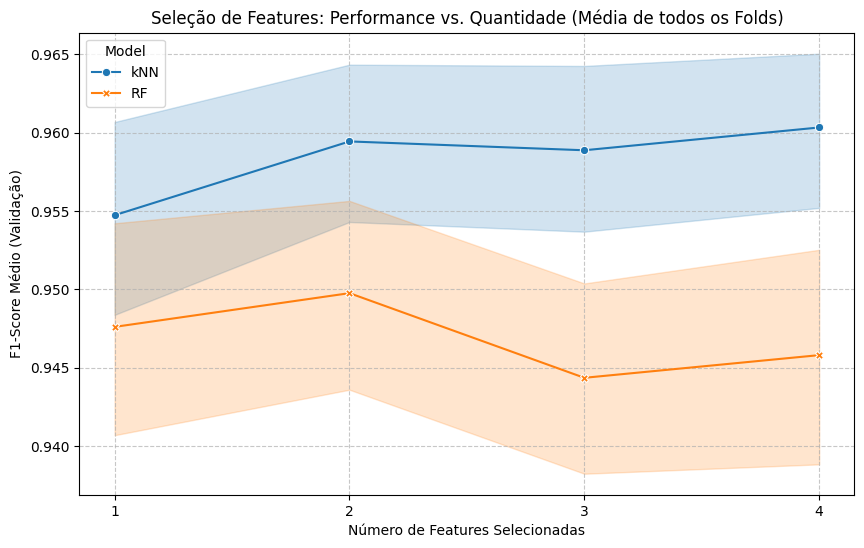

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Extrair os dados de TODAS as repetições e folds
dados_features = []
for entry in experiment_results:
    # Não precisamos do ID da repetição/fold para o gráfico, 
    for model_data in entry['models']:
        model_name = model_data['model_name']        
        # Iterar sobre os scores das features
        for val in model_data['validation_features_scores']:
            k = val['k_features']
            f1 = val['F1']
            
            dados_features.append({
                'Model': model_name,
                'k_Features': k,
                'Validation_F1': f1
            })


# 2. Criar o DataFrame
df_features = pd.DataFrame(dados_features)
print(df_features)
# 3. Gerar o Gráfico
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_features, 
    x='k_Features', 
    y='Validation_F1', 
    hue='Model',       # Uma linha de cor diferente para cada modelo
    style='Model',     # Estilos de linha diferentes
    markers=True, 
    dashes=False
)

plt.title('Seleção de Features: Performance vs. Quantidade (Média de todos os Folds)')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1-Score Médio (Validação)')
plt.grid(True, linestyle='--', alpha=0.7)

# Forçar o eixo X a mostrar apenas números inteiros (1, 2, 3...)
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()

In [84]:

idx_0 = np.where(y == 0)[0]       # 50 Setosa
idx_1 = np.where(y == 1)[0][:30]  # primeiras 30 Versicolor
idx_2 = np.where(y == 2)[0][:10]  # primeiras 10 Virginica

idx_final = np.concatenate([idx_0, idx_1, idx_2])

X = X[idx_final]
y = y[idx_final]

models = {
    "kNN": KNeighborsClassifier(),
}
model_parameters = {
    "kNN": {"n_neighbors": [1,3,5,7,9,11,13,15]},
}


Dataset shape: (12170, 554)


## Exercise 3.1 - Baseline

### Train-only

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Scaler detetado: StandardScaler (será ajustado apenas ao treino em cada split).


,Model,Accuracy,Precision,Recall,F1
0,Random,0.200082,0.040033,0.200082,0.066717
1,OneR,0.389975,0.239379,0.389975,0.270881
2,kNN,1.000000,1.000000,1.000000,1.000000


,0,1,2,3,4,5,6
0,7301,0,0,0,4,0,0
1,1503,1503,0,0,1503,0,0
2,1340,0,1340,0,1340,0,0
3,2345,0,0,2314,2283,0,0
4,2389,0,0,0,4667,0,0
5,1531,0,0,0,1501,1516,0
6,716,0,0,0,704,0,710


### TT 70-30

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Scaler detetado: StandardScaler (será ajustado apenas ao treino em cada split).


,Model,Accuracy,Precision,Recall,F1
0,Random,0.197882,0.039157,0.197882,0.065377
1,OneR,0.384337,0.234620,0.384337,0.265777
2,kNN,0.632386,0.638072,0.632386,0.626015


,0,1,2,3,4,5,6
0,2125,4,0,1,0,0,0
1,434,206,226,0,433,0,0
2,434,61,371,0,433,0,0
3,711,0,0,394,944,7,5
4,700,0,0,390,942,4,4
5,438,0,0,63,447,268,80
6,213,0,0,33,234,107,52


### 1x10-fold cross-validation

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Scaler detetado: StandardScaler (será ajustado apenas ao treino em cada split).


,Model,strategy,Acc_Mean,Acc_Std,Prec_Mean,Prec_Std,Rec_Mean,Rec_Std,F1_Mean,F1_Std
0,Random,most_frequent,0.216151,0.050947,0.049317,0.028167,0.216151,0.050947,0.079470,0.039040
1,OneR,NaN,0.386799,0.016254,0.251617,0.040371,0.386799,0.016254,0.279699,0.031719
2,kNN,NaN,0.666438,0.108882,0.678710,0.110670,0.666438,0.108882,0.660599,0.113277


,0,1,2,3,4,5,6
0,2435,0,0,0,0,0,0
1,1503,0,0,0,0,0,0
2,1340,0,0,0,0,0,0
3,2314,0,0,0,0,0,0
4,2352,0,0,0,0,0,0
5,1516,0,0,0,0,0,0
6,710,0,0,0,0,0,0


### 1x10-fold cross-validation

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Scaler detetado: StandardScaler (será ajustado apenas ao treino em cada split).
running new version


In [9]:
from experiments.experimentsv2 import Experiment
models = {
    "kNN": KNeighborsClassifier()
}
model_parameters = {
    "kNN": {"n_neighbors": range(1, 16, 2)}
}
exp = Experiment(X, y, models, model_parameters, subjects=subjects)


15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [33]:
display(Markdown("## Exercise 3.2 - Baseline"))
display(Markdown("### Train-only"))
exp = Experiment(X_scaled, y, models, model_parameters, subjects=subjects)
results,cms, cm_total=exp.run_train_only()
display(results[["Model","n_neighbors", "Accuracy", "Precision", "Recall", "F1"]])
display(pd.DataFrame(cm_total))

display(Markdown("### TT 70-30"))
exp = Experiment(X_scaled, y, models, model_parameters, subjects=subjects)
results,cms, cm_total=exp.run_train_test(0.3)
display(results[["Model","n_neighbors", "Accuracy", "Precision", "Recall", "F1"]])
display(pd.DataFrame(cm_total))

display(Markdown("### TVT 40-30-30"))
exp = Experiment(X_scaled, y, models, model_parameters, subjects=subjects)
exp.run_train_test_validation(val_size=0.3, test_size=0.3)
display(results[["Model","n_neighbors", "Accuracy", "Precision", "Recall", "F1"]])
display(pd.DataFrame(cm_total))


display(Markdown("### 10x10CV"))
exp = Experiment(X_scaled, y, models, model_parameters, subjects=subjects)
results, cms, cm_total = exp.run_cross_validation(n_splits=10, n_repeats=10)
display(results[["Model", "n_neighbors", "Acc_Mean", "Acc_Std", "Prec_Mean", "Prec_Std", "Rec_Mean", "Rec_Std", "F1_Mean", "F1_Std"]])
display(pd.DataFrame(cm_total))

## Exercise 3.2.1 - Baseline

### Train-only

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


,Model,n_neighbors,Accuracy,Precision,Recall,F1
0,kNN,1,1.000000,1.000000,1.000000,1.000000
1,kNN,3,0.954725,0.954462,0.954725,0.953985
2,kNN,5,0.934429,0.934489,0.934429,0.932184
3,kNN,7,0.926623,0.926908,0.926623,0.923730
4,kNN,9,0.918324,0.919034,0.918324,0.914250
5,kNN,11,0.913887,0.916147,0.913887,0.908958
6,kNN,13,0.910518,0.913420,0.910518,0.904988
7,kNN,15,0.904108,0.907490,0.904108,0.897010


,0,1,2,3,4,5,6
0,19477,1,0,1,1,0,0
1,25,11808,191,0,0,0,0
2,13,50,10657,0,0,0,0
3,208,0,0,16855,1421,28,0
4,233,0,0,1184,17368,13,18
5,0,0,0,217,46,11537,328
6,0,0,0,145,60,2357,3118


### TT 70-30

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Split por participantes: 11 treino, 4 teste


,Model,n_neighbors,Accuracy,Precision,Recall,F1
0,kNN,1,0.635452,0.640563,0.635452,0.628205
1,kNN,3,0.632107,0.641804,0.632107,0.621620
2,kNN,5,0.635173,0.644417,0.635173,0.619417
3,kNN,7,0.642977,0.648583,0.642977,0.623447
4,kNN,9,0.642977,0.652391,0.642977,0.621304
5,kNN,11,0.644370,0.655775,0.644370,0.619970
6,kNN,13,0.647157,0.659786,0.647157,0.621068
7,kNN,15,0.642977,0.655658,0.642977,0.615921


,0,1,2,3,4,5,6
0,5676,4,0,0,0,0,0
1,10,1356,2098,0,0,0,0
2,17,333,3114,0,0,0,0
3,104,0,0,3711,1626,45,10
4,70,0,0,3413,1928,9,20
5,0,0,0,629,139,2381,307
6,0,0,0,301,170,1017,216


### TVT 40-30-30

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Split manual aplicado:
  Treino: 7 participantes → 6187 amostras
  Val:    4 participantes → 3222 amostras
  Teste:  4 participantes → 2761 amostras



,Model,n_neighbors,Accuracy,Precision,Recall,F1
0,kNN,1,0.635452,0.640563,0.635452,0.628205
1,kNN,3,0.632107,0.641804,0.632107,0.621620
2,kNN,5,0.635173,0.644417,0.635173,0.619417
3,kNN,7,0.642977,0.648583,0.642977,0.623447
4,kNN,9,0.642977,0.652391,0.642977,0.621304
5,kNN,11,0.644370,0.655775,0.644370,0.619970
6,kNN,13,0.647157,0.659786,0.647157,0.621068
7,kNN,15,0.642977,0.655658,0.642977,0.615921


,0,1,2,3,4,5,6
0,5676,4,0,0,0,0,0
1,10,1356,2098,0,0,0,0
2,17,333,3114,0,0,0,0
3,104,0,0,3711,1626,45,10
4,70,0,0,3413,1928,9,20
5,0,0,0,629,139,2381,307
6,0,0,0,301,170,1017,216


### 10x10CV

15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


,Model,n_neighbors,Acc_Mean,Acc_Std,Prec_Mean,Prec_Std,Rec_Mean,Rec_Std,F1_Mean,F1_Std
0,kNN,1,0.646310,0.088938,0.660058,0.091498,0.646310,0.088938,0.636693,0.094150
1,kNN,3,0.659431,0.087863,0.669211,0.089941,0.659431,0.087863,0.642933,0.094412
2,kNN,5,0.664436,0.085953,0.674771,0.087281,0.664436,0.085953,0.644802,0.092721
3,kNN,7,0.669679,0.082491,0.680184,0.088532,0.669679,0.082491,0.647426,0.091600
4,kNN,9,0.671899,0.084695,0.680872,0.089519,0.671899,0.084695,0.647937,0.093582
5,kNN,11,0.676561,0.083366,0.687953,0.089424,0.676561,0.083366,0.650742,0.092955
6,kNN,13,0.679081,0.083360,0.692022,0.087763,0.679081,0.083360,0.652649,0.093543
7,kNN,15,0.682267,0.082515,0.693910,0.087962,0.682267,0.082515,0.655412,0.092698


,0,1,2,3,4,5,6
0,23813,11,28,58,440,0,0
1,76,7584,7370,0,0,0,0
2,137,3529,9725,0,9,0,0
3,308,0,0,14078,8090,372,292
4,334,0,0,12257,10596,196,137
5,1,0,0,1527,1326,8531,3775
6,0,0,0,760,595,3573,2172


In [ ]:
import numpy as np

from experiments.experiment import create_feature_ranking

# 1. Obter IDs únicos de sujeitos
unique_subjects = np.unique(subjects)
np.random.seed(42) # Para reprodutibilidade
np.random.shuffle(unique_subjects)

# 2. Divisão 40/30/30
n_sub = len(unique_subjects)
train_idx = int(0.4 * n_sub)
val_idx = int(0.7 * n_sub)

sub_train = unique_subjects[:train_idx]
sub_val   = unique_subjects[train_idx:val_idx]
sub_test  = unique_subjects[val_idx:]

print(f"Sujeitos Treino: {sub_train}")
print(f"Sujeitos Validação: {sub_val}")
print(f"Sujeitos Teste: {sub_test}")

# 3. Criar o Ranking de Features usando APENAS os dados de Treino
ranking, importances = create_feature_ranking(
    X_scaled, y, 
    n_neighbors=100, 
    subjects=subjects, 
    train_subjects=sub_train
)



Sujeitos Treino: [ 9 11  0 13  5  8]
Sujeitos Validação: [ 2  1 14  4]
Sujeitos Teste: [ 7 10 12  3  6]
Accuracy na Validação (Top 100 features): 0.5685


In [37]:
import numpy as np
import pandas as pd

np.save('relief_ranking_indices.npy', ranking)
np.save('relief_feature_scores.npy', importances)

In [ ]:

display(Markdown("## Exercise 3.3 - Feature Selection"))

# 1. Carregar o ranking que guardaste anteriormente
try:
    ranking_importado = np.load('relief_ranking_indices.npy')
    print(" Ranking carregado com sucesso!")
except FileNotFoundError:
    print(" Erro: O ficheiro do ranking não foi encontrado.")
    ranking_importado = None

# 2. Definir os modelos e parâmetros (como já tinhas)
models = {
    "kNN": KNeighborsClassifier()
}

model_parameters = {
    "kNN": {"n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]},
}

# 3. Inicializar a classe Experiment
exp = Experiment(X_scaled, y, models, model_parameters, subjects=subjects)

# 4. Executar o TVT usando o ranking pré-computado
# IMPORTANTE: Passamos o ranking_importado e os teus sujeitos definidos
models_results = exp.run_tvt_with_feature_selection(
    feature_ranking=ranking_importado,
    train_subjects=sub_train,
    val_subjects=sub_val,
    test_subjects=sub_test
)


## Exercise 3.3 - Feature Selection

 Ranking carregado com sucesso!
15 participantes detectados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Split manual aplicado:
  Treino: 6 participantes → 4566 amostras
  Val:    4 participantes → 3173 amostras
  Teste:  5 participantes → 4431 amostras

✓ Usando feature ranking pré-computado

Modelo: kNN
  → Testando número de features...
  ✓ Melhor k=309 (F1=0.6702)
  → Otimizando parâmetros...
  ✓ Melhores params: {'n_neighbors': 11} (F1=0.6736)
  ✓ Teste final: F1=0.6303



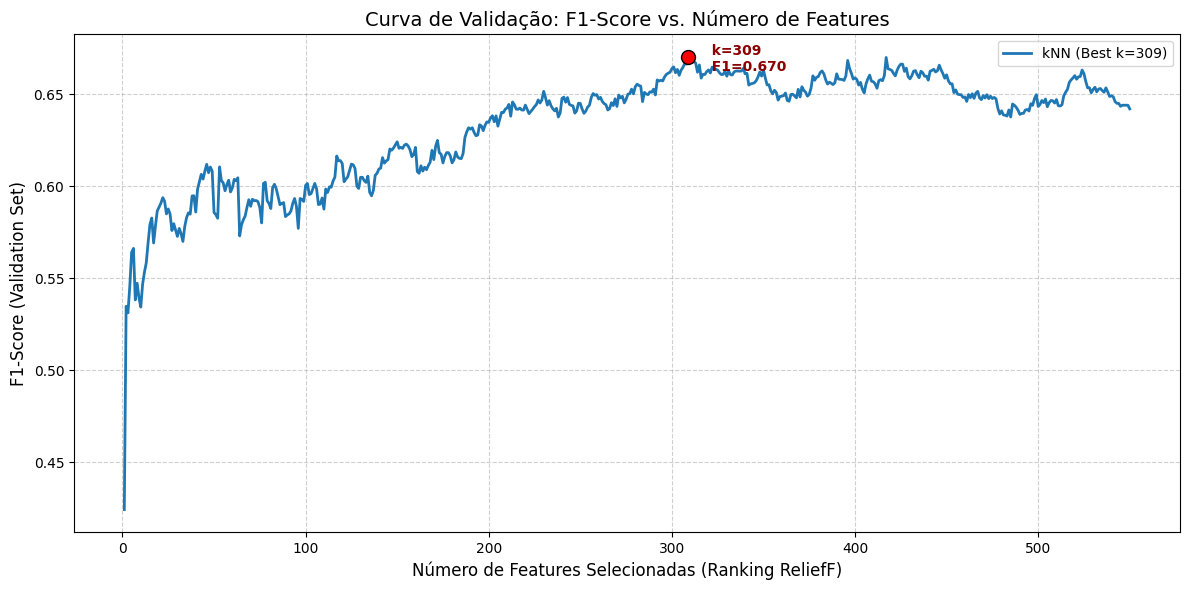

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_selection_elbow(models_results):
    plt.figure(figsize=(12, 6))
    
    for model_res in models_results:
        # Extrair os dados de validação
        val_data = model_res['validation']
        # 'test' contém o dicionário final com o nome e melhor k
        name = model_res['test']['model']
        
        # Criar listas de K e F1
        ks = [entry['k_features'] for entry in val_data]
        f1s = [entry['F1'] for entry in val_data]
        
        # O melhor k e F1 para marcar no gráfico
        best_k = model_res['test']['k_features']
        # Procuramos o F1 correspondente ao melhor_k na lista de validação
        best_f1 = next(item['F1'] for item in val_data if item['k_features'] == best_k)
        
        # CORREÇÃO AQUI: apenas um 'f'
        plt.plot(ks, f1s, label=f"{name} (Best k={best_k})", linewidth=2)
        
        # Marcar o ponto de "cotovelo" (elbow)
        plt.scatter(best_k, best_f1, color='red', s=100, zorder=5, edgecolors='black')
        plt.annotate(f'  k={best_k}\n  F1={best_f1:.3f}', 
                     (best_k, best_f1), 
                     textcoords="offset points", 
                     xytext=(10,-10), 
                     ha='left', 
                     fontsize=10, 
                     fontweight='bold',
                     color='darkred')

    plt.title('Curva de Validação: F1-Score vs. Número de Features', fontsize=14)
    plt.xlabel('Número de Features Selecionadas (Ranking ReliefF)', fontsize=12)
    plt.ylabel('F1-Score (Validation Set)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Chamar a função
plot_feature_selection_elbow(models_results)